---
# COMPUTER VISION FINAL PROJECT:
### In the name of deep learning
---

This assignment is the final project for computer vision, consisting of two assignments. This is done by Afraz Salim, Victor Gueorguiev and Nils Vanherpe. The goal of these two assignments will be to train end-to-end neural networks for the purposes of image classification and to fine-tine pre-trained neural network architectures for image segmentation.

A link to the pre-trained models can be found in this Dropbox folder:

https://www.dropbox.com/sh/zmq4lapdlvotjh9/AAAyZ2NeC_AFoZAQn1hZjU3ra?dl=0

---
## STEP 0: Libraries and Initialization
---
Here we are loading libraries and initializing necessary global variables

In [0]:
!pip install segmentation-models

# install and load package to perform transfer learning on segmentation tasks.
import segmentation_models as sm

import os
import sys
import cv2
import tarfile
import itertools
import numpy as np
from urllib import request
from google.colab import drive
# for plotting some example images
from google.colab.patches import cv2_imshow

# for other model experimentations and dimensionality reductions plus EDA
from sklearn import manifold
from sklearn import tree, ensemble, neighbors, linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, confusion_matrix, f1_score, precision_score, recall_score

# needed to read in the .xml annotations
import xml.etree.ElementTree as ET
import tensorflow.keras as keras
# we load up keras the standard VGG16 pre-trained networks
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
# load up pre-trained networks for experimentation
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras import backend as K
# load up some basic callbacks
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy
# load up regularization terms
from tensorflow.keras.regularizers import l1_l2, l2, l1
from tensorflow.keras.utils import get_custom_objects
from keras.preprocessing import image

#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model

# laod all necessary model layers that we will be using and experimenting with
from tensorflow.keras.layers import Reshape, Dense, Activation, Conv2D, GlobalAveragePooling2D,  MaxPooling2D, Flatten, Dropout, Input, concatenate, add, Conv2DTranspose, ZeroPadding2D, UpSampling2D, Add, BatchNormalization,Lambda

# load necessary losses and optimizers
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import losses

import pandas as pd

# load plotting libraries for visualization
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

## NB function for using pre-trained transfer model which has been fine-tuned
def f1_weighted(true, pred): #shapes (batch, 4)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    #predLabels = K.argmax(pred, axis=-1)
    #pred = K.one_hot(predLabels, 4) 


    ground_positives = K.sum(true, axis=0)       # = TP + FN
    pred_positives = K.sum(pred, axis=0)         # = TP + FP
    true_positives = K.sum(true * pred, axis=0)  # = TP
        #all with shape (4,)

    precision = (true_positives + K.epsilon()) / (pred_positives + K.epsilon()) 
    recall = (true_positives + K.epsilon()) / (ground_positives + K.epsilon()) 
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #not sure if this last epsilon is necessary
        #matematically not, but maybe to avoid computational instability
        #still with shape (4,)

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives)
    weighted_f1 = K.sum(weighted_f1)


    return 1 - weighted_f1 #for metrics, return only 'weighted_f1'


# to loop over files in a given folder
import glob

# for segmentation from pre-trained networks, get the necessary backbone and preprocessing function 
BACKBONE = 'resnet34'
preprocess_input_unet = sm.get_preprocessing(BACKBONE)


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Adjust necessary meta-parameters for this script. For instance, check and download data if needed. First-time users of this script are suggested to use this option.

NB: Please set the DO_TRAINING parameter to True to perform re-training of models and to False to perform training/fine-tuning of saved models fetched from a Dropbox/Google Drive repository.



In [0]:
# fetch new data or not: Values are True/False
FETCH_NEW_DATA = True
# NB set this if you would like to train from scratch or learn using the pre-trained networks supplied
DO_TRAINING = True

CLASSIF_IMG_WIDTH = 150
CLASSIF_IMG_HEIGHT = 150

---
## STEP 1: Data Preparation
---

Here we download and save the VOC 2009 dataset, if it has not been fetched before. This can be overridden with the above option FETCH_NEW_DATA, which may be set to True to ensure new data is fetched.

---
### STEP 1.1: Fetch Data and Save to Directory
---

In [0]:
if FETCH_NEW_DATA:
  !wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
  !tar -xf VOCtrainval_11-May-2009.tar --totals

voc_root_folder = "/content/VOCdevkit/VOC2009"
# define relevant subfolders 
img_folder = os.path.join(voc_root_folder, 'JPEGImages')
ann_folder = os.path.join(voc_root_folder, 'Annotations')
set_folder = os.path.join(voc_root_folder, 'ImageSets', 'Main')
segmentation_set_folder = os.path.join(voc_root_folder, 'ImageSets', 'Segmentation')
segmentation_object_folder = os.path.join(voc_root_folder, 'SegmentationClass')

--2020-06-01 21:03:44--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  15.4MB/s    in 59s     

2020-06-01 21:04:43 (15.1 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 250MiB/s)


Here is load up the data and define train, validation and test sets for the assignments to follow. We use a DataGenerator which, as the name suggests, acts as a generator to load up batches of image instances, together with labels for classification, to be fed into the the classification model later.

Below we define some helper functions. We use one to enter the ImageSet/Main folder to extract the unique categories for classification in order to name our Y labels for classification. We also use helper functions to enter the annotation XML files to extract the objects present in an image, which can sometimes be many. Thus, this is a multi-label classification task.

In [0]:
def array_to_labels(onehot_array, label_to_class):
    labels = []
    idx = np.where(onehot_array == 1)[0]
    return [label_to_class[i] for i in idx]

def labels_to_array(labels_array, label_to_class):
    labels = [0 for i in range(len(label_to_class))]
    for label in labels_array:
      idx = np.where(np.array(label_to_class) == label)[0][0]
      labels[idx] = 1
    return labels
  
def counter_to_dict(counter_array, label_to_class):
    labels = {}
    for label, value in counter_array.items():
      idx = np.where(np.array(label_to_class) == label)[0][0]
      labels[idx] = value
    return labels


def get_categories(labels_dir):
    """
    Get the object categories
    
    Args:
        label_dir: Directory that contains object specific label as .txt files
    Raises:
        FileNotFoundError: If the label directory does not exist
    Returns:
        Object categories as a list
    """
    
    if not os.path.isdir(labels_dir):
      raise FileNotFoundError
    
    else:
      categories = []
      
      for file in os.listdir(labels_dir):
        # loop over contents of the folder and get unique class names
        # easier than using a unique operation over the annotation XML files
        if file.endswith("_train.txt"):
            categories.append(file.split("_")[0])
      
      return categories

# annotation operations
def load_annotation(annot_filename):
  """
  Load a file as an xml tree file 
  
  Args:
      annot_filename: Name of the annotation XML file to load
  Returns:
      xml file tree
  """
  try:
    xml = ET.parse(annot_filename)
  except: 
    print("Unable to read XML file format.")
    exit
  return xml.getroot()

def encode_labels(target):
  """
  Encode multiple labels using 1/0 encoding. Make sure they are easy difficulty 
  
  Args:
      target: xml tree file
  Returns:
      torch tensor encoding labels as 1/0 vector
  """
  
  ls = target.findall('object')

  j = []
  for obj in ls:
    class_label = obj.find('name').text
    difficulty = obj.find('difficult').text
    if int(difficulty) == 0:
      j.append(object_categories.index(class_label))
  
  k = np.zeros(len(object_categories))
  k[j] = 1

  return k

def get_labels(Y, object_categories):
  labels_list = []
  for y in Y:
    labels_list.append(array_to_labels(y, object_categories))
  return labels_list
      

def get_classification_data_pair(annot_filename, filter_difficulty = True):
  """
  Function to return difficult/non_difficult training example pairs

  Args:
      annot_filename: The name of the annotation file to load annotations from
      filter_difficult: default = True. Whether to filter difficult examples out
  Return:
      Tuple (X_instance, y_instance) of training image name for loading and its label 
  """
  annotation = load_annotation(annot_filename)
  y_instance = encode_labels(annotation)
  X_instance = os.path.basename(annot_filename).split('.')[0] + '.jpg'
  return (X_instance, y_instance)

def get_segmentation_data_pair(segmentation_filename, filter_difficulty = True):
  """
  Function to return difficult/non_difficult training example pairs

  Args:
      segmentation_filename: The name of the image/mask files (without file extension) to load image/mask from
      filter_difficult: default = True. Whether to filter difficult examples out
  Return:
      Tuple (X_instance, y_instance) of training image name (X_instance) and mask image name (y_instance)
      for loading via a DataGenerator object. They are in JPEG, PNG format respectively.
  """
  y_instance = os.path.basename(segmentation_filename).split('.')[0] + '.png'
  X_instance = os.path.basename(segmentation_filename).split('.')[0] + '.jpg'
  return (X_instance, y_instance)

In this section of code we use the helper functions defined above to extract the unique classification categories of the images. We then enter the Annotations folder and iteratively create the Y labels for each image instance, as well as the name of the image which will later be loaded from the JPEGImages folder by the Image Data Generators.

We also fetch training data for segmentation via JPEGImages and SegmentationClass folders by checking the Annotations folder for annotations labelling image data points as available for segmentation. We build a list of these filenames and append then to be fed into two ImageDataGenerator objects for segmentation: One for the input image/data point, and one for the corresponding mask.

We then also define a list of all classification tokens to use to count the images by class, so as to measure class imbalance.

In [0]:
object_categories = get_categories(set_folder)

Y = []
X = []

Y_segmentation = []
X_segmentation = []

for file_annot in glob.glob(ann_folder + '/*.xml'):
  X_current_class_type, y_label = get_classification_data_pair(file_annot, filter_difficulty = True)
  Y.append(y_label)
  X.append(X_current_class_type)

with open(segmentation_set_folder + '/trainval.txt','r') as f: 
  for line in f:
    file_seg = line.strip()
    # here the y_segment_label is the mask file in png format located in the SegmentationClass folder
    # of the dataset
    X_current_segment_type, y_segment_label = get_segmentation_data_pair(file_seg, filter_difficulty = True)
    Y_segmentation.append(y_segment_label)
    X_segmentation.append(X_current_segment_type)

X = np.array(X)
Y = np.array(Y)

X_segmentation = np.array(X_segmentation)
Y_segmentation = np.array(Y_segmentation)

Y_labels = np.array(get_labels(Y, object_categories))
classification_img_metadata_df = pd.DataFrame({'filename': X, 'labels': Y_labels})



---
#### STEP 1.1.1: Basic EDA on Class Imbalance
---

In this section we compute some summary statistics regarding the total instances/data points present in each of the classes for the classification task. We note that there is indeed a large class imbalance, in particular in extremes of the most represented class (People) and the least represented class (Sheep). Indeed, perhaps the classifier will agree that all people are merely sheep?

We can see that people make a majority class in the datast with >3000 instances shown here on this log scale plot.

This will become relevant later in the classification tasks as we will see how the classification models tend to overfit to this class, even with preventative measures in place. It seems that there are not enough data points in the data in order to make accurate predictions across all classes, especially minority classes.

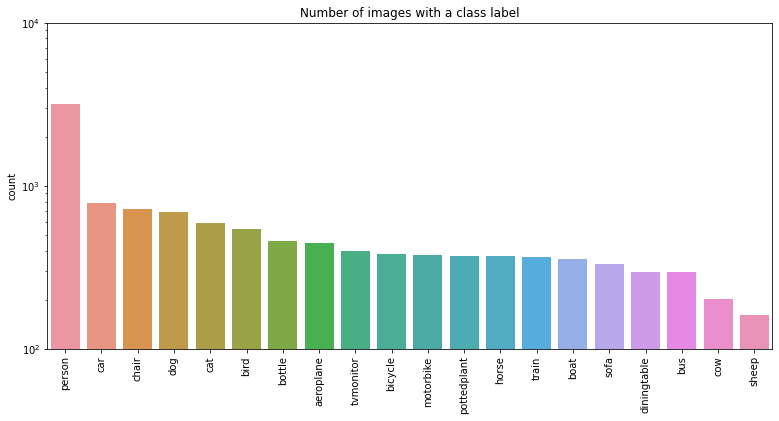

In [0]:
labels_count = Counter(label for lbs in classification_img_metadata_df['labels'] for label in lbs)
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}
model_class_weights = counter_to_dict(labels_count, object_categories)

all_labels = [label for lbs in classification_img_metadata_df['labels'] for label in lbs]
labels_count = Counter(all_labels)

plt.figure(figsize=(13,6))
ax = sns.countplot(all_labels, order=[k for k, _ in labels_count.most_common()], log=True)
ax.set_title('Number of images with a class label')
ax.set_ylim(1E2, 1E4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

-------------------------------------------------------
### STEP 1.2 Data Creation and Train/Validation/Test Set Splits
-------------------------------------------------------

Here we create the train, validation and test splits for modelling. The test data is taken as 25% of the full data. Of the remaining 75%, 60% is used as training and 40% as validation.

This is then structured as a Pandas dataframe for each set: training, validation and test. 

We also incorporate automated preprocessing steps for data augmentation for both the data classification tasks and data segmentation tasks. This is found to be beneficial to prevent overfitting and to induce extra examples which are somewhat perturbed and different from what was seen before, in order to ensure the model generalizes adequately. The preprocessing includes performing random transformations such as vertical/horizontal flips and rotations.

-------------------------------------------------------
#### STEP 1.2.1: Data for Classification
-------------------------------------------------------

The structure of the classification data is a  dataframe with an "image_name" column which stores the names of the training images located in JPEGImages. Then, there are N columns for the N unique categories for our multi-label classification problem, each taking on binary 0/1 values. The structure of the dataframe is needed so as to be fed into the required Image Data Generator input.

In [0]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.30, random_state=42)

train_df = pd.DataFrame({'image_name': X_train})
train_df[object_categories] = pd.DataFrame(list(Y_train), index=train_df.index)

validation_df = pd.DataFrame({'image_name': X_validation})
validation_df[object_categories] = pd.DataFrame(list(Y_validation), index=validation_df.index)

#flip images to decrease overfitting
TrainDatagen = ImageDataGenerator(preprocessing_function=inception_preprocess_input, horizontal_flip=True, vertical_flip=True, rotation_range=90)
ValidationDatagen = ImageDataGenerator(preprocessing_function=inception_preprocess_input, horizontal_flip=True, vertical_flip=True, rotation_range=90)
VisualDatagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90)

TrainGenerator = TrainDatagen.flow_from_dataframe(dataframe=train_df, 
                                            directory=img_folder + "/", 
                                            x_col="image_name", 
                                            y_col=object_categories,
                                            class_mode="raw",
                                            target_size=(CLASSIF_IMG_WIDTH,CLASSIF_IMG_HEIGHT), 
                                            batch_size=128)

ValidationGenerator = ValidationDatagen.flow_from_dataframe(dataframe=validation_df, 
                                            directory=img_folder + "/", 
                                            x_col="image_name", 
                                            y_col=object_categories,
                                            class_mode="raw",
                                            target_size=(CLASSIF_IMG_WIDTH,CLASSIF_IMG_HEIGHT), 
                                            batch_size=128)

VisualGeneratorGenerator = VisualDatagen.flow_from_dataframe(dataframe=train_df, 
                                            directory=img_folder + "/", 
                                            x_col="image_name", 
                                            y_col=object_categories,
                                            class_mode="raw",
                                            target_size=(CLASSIF_IMG_WIDTH,CLASSIF_IMG_HEIGHT), 
                                            batch_size=128)

Found 5472 validated image filenames.
Found 2346 validated image filenames.
Found 5472 validated image filenames.


-------------------------------------------------------
#### STEP 1.2.1: Data for Segmentation
-------------------------------------------------------

The structure of the segmentation data is a  dataframe with an "image_name" column which stores the names of the training images located in JPEGImages. Then, there are mask images for the $N^2$ unique pixel values for our image-to-image segmentation problem, each taking on 20 values for each possible class for each pixel. These segmentation masks are located in the SegmentationClass folder as png files. The structure of the dataframe will contain the names of these masks in the "mask_name" column. The generator now changes to a tuple, or more specifically a pair of ImageDataGenerators, which generate a training image and mask image for each batch


In [0]:
X_seg_train, X_seg_validation, Y_seg_train, Y_seg_validation = train_test_split(X_segmentation, Y_segmentation, test_size=0.30, random_state=42)


segmentation_train_df = pd.DataFrame({'image_name': X_seg_train, 'mask_name': Y_seg_train})

segmentation_validation_df = pd.DataFrame({'image_name': X_seg_validation, 'mask_name': Y_seg_validation})

seed = 909 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
SegmentationTrainFeatureDatagen = ImageDataGenerator(preprocessing_function=preprocess_input_unet, rescale=1./255) # custom fuction for each image you can use resnet one too.
SegmentationTrainMaskDatagen = ImageDataGenerator(rescale=1./255)  # to make mask as feedable formate (256,256,1)

SegmentationValidationFeatureDatagen = ImageDataGenerator(preprocessing_function=preprocess_input_unet, rescale=1./255) 
SegmentationValidationMaskDatagen = ImageDataGenerator(rescale=1./255)


# Here we do the TRAIN set

SegmentationTrainFeatureGenerator = SegmentationTrainFeatureDatagen.flow_from_dataframe(dataframe=segmentation_train_df, 
                                            directory=img_folder + "/", 
                                            x_col="image_name", 
                                            class_mode=None, 
                                            seed=seed,  
                                            target_size=(128,128), 
                                            batch_size=20)

SegmentationTrainMaskGenerator = SegmentationTrainMaskDatagen.flow_from_dataframe(dataframe=segmentation_train_df, 
                                            directory=segmentation_object_folder + "/", 
                                            x_col="mask_name", 
                                            class_mode=None, 
                                            seed=seed,    
                                            color_mode='grayscale',                                                                                  
                                            target_size=(128,128),                                             
                                            batch_size=20)

SegmentationTrainGenerator = zip(SegmentationTrainFeatureGenerator, SegmentationTrainMaskGenerator)

# Here we do the VALIDATION set

SegmentationValidationFeatureGenerator = SegmentationValidationFeatureDatagen.flow_from_dataframe(dataframe=segmentation_validation_df, 
                                            directory=img_folder + "/", 
                                            x_col="image_name", 
                                            class_mode=None, 
                                            seed=seed,                                            
                                            target_size=(128,128), 
                                            batch_size=20)

SegmentationValidationMaskGenerator = SegmentationValidationMaskDatagen.flow_from_dataframe(dataframe=segmentation_validation_df, 
                                            directory=segmentation_object_folder + "/", 
                                            x_col="mask_name", 
                                            class_mode=None, 
                                            seed=seed,     
                                            color_mode='grayscale',                                                                                  
                                            target_size=(128,128),                                             
                                            batch_size=20)

SegmentationValidationGenerator = zip(SegmentationValidationFeatureGenerator, SegmentationValidationMaskGenerator)


Found 1049 validated image filenames.
Found 1049 validated image filenames.
Found 450 validated image filenames.
Found 450 validated image filenames.


Here we define a helper function to visualize output of classification models and our defined image generators above.

We also define some helper functions for model monitoring and confusion matrix plotting for individual classes for later model diagnoses.

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, images_labels = [], object_categories = [], plot_labels = True):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    label_id = 0
    for img, ax in zip( images_arr, axes):
        ax.imshow( img)
        if plot_labels:
          labels = array_to_labels(images_labels[label_id], object_categories)
          ax.set_title(str(labels))
        ax.axis('off')
        label_id += 1
    plt.tight_layout()
    plt.show()

def custom_plot_confusion_matrix(cm, classes, title, ax):

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(classes)
    ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(title)
    ax.grid(False)

def plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False):
    fig, axes = plt.subplots(int(np.ceil(len(label_to_class) / 4)), 4, figsize=(15, 40))
    axes = axes.flatten()
    for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
        tn, fp, fn, tp = conf_matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
        recall = tp / (tp + fn + sys.float_info.epsilon)
        precision = tp / (tp + fp + sys.float_info.epsilon)
        custom_plot_confusion_matrix(
            np.array([[tp, fn], [fp, tn]]),
            classes=['+', '-'],
            title=f'Label: {label_to_class[i]}\nf1={f1:.5f}\nrecall={recall:.5f}\nprecision={precision:.5f}',
            ax=axes[i]
        )
        plt.tight_layout()
    if save_plot:
        plt.savefig('confusion_matrices.png', dpi=50)



Here we plot a few example images and associated classes labels. We plot 5 images from the training data generator, 5 images from the validation generator.

Then, we plot some example images from the segmentation dataset, 5 images from the training data generator and associated masks from the training mask generator.

We can see the images after they have undergone preprocessing which includes performing random transformations such as vertical/horizontal flips and rotations.

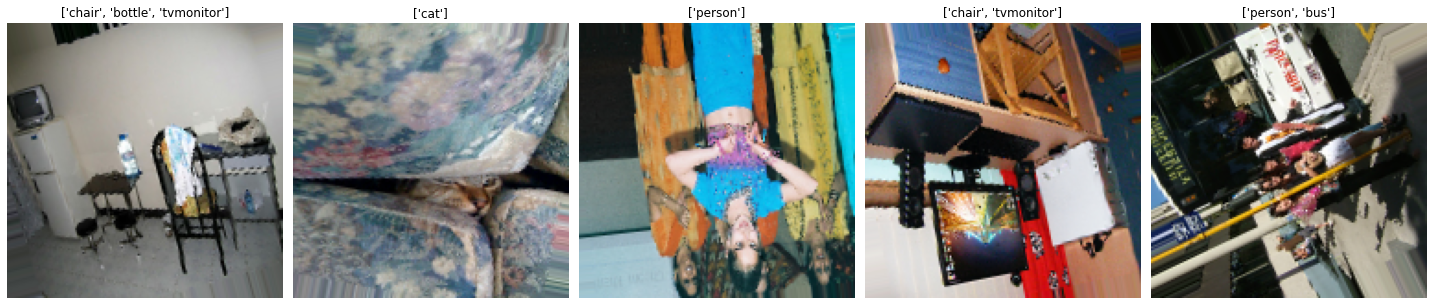

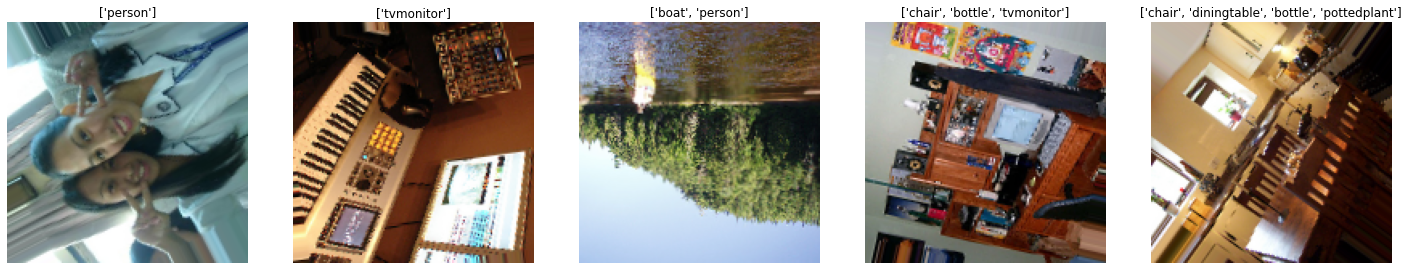

In [0]:
sample_training_images, sample_training_labels = next(VisualGeneratorGenerator)
plotImages(sample_training_images, sample_training_labels, object_categories)

sample_validation_images, sample_validation_labels = next(VisualGeneratorGenerator)
plotImages(sample_validation_images, sample_validation_labels, object_categories)



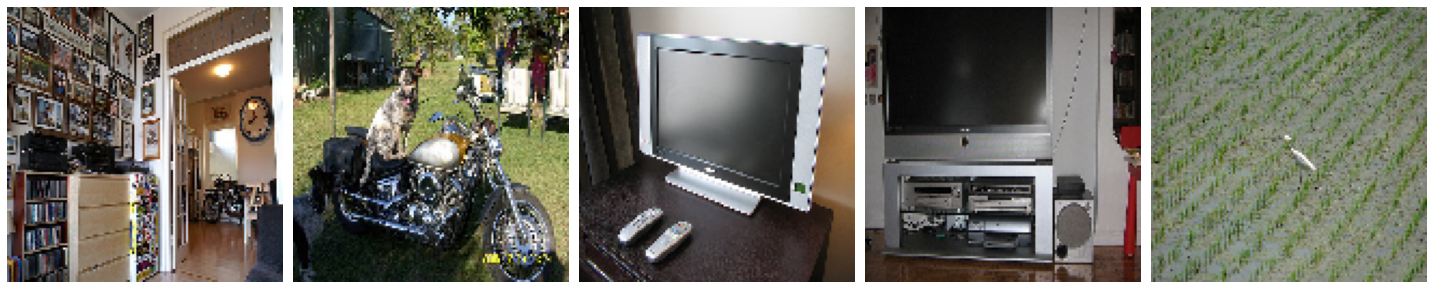

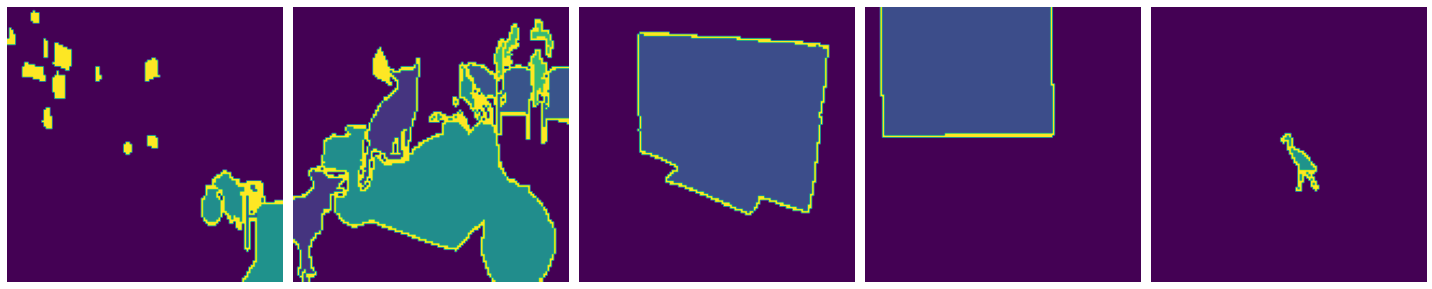

In [0]:
sample_training_images, sample_training_masks = next(SegmentationValidationGenerator)

plotImages(sample_training_images, plot_labels=False)
plotImages(np.squeeze(sample_training_masks), plot_labels=False)


In [0]:
labels = to_categorical(sample_training_masks, num_classes=20)

---
## STEP 2: Classification Tasks
---

In the following section, we will be working with the PASCAL VOC 2009 data as a multi-label classification task. For this task, images are fed to our models with only rescaling done to ensure that the dimensions conform to the expected size and crop of the expected input. The target is a 20-dimensional binary output vector encoding which class is present in an image. In this scheme there can be more than one object present in the scene/image. 

As mentioned in the data preparation, we have opted to simplify the classification task somewhat as compared to the original PASCAL VOC data challenge. In the original data challenge, we are expected to perform joint object detection and classification by labelling objects with bounding boxes and classifying them. In this work, we opt for a multi-label classification approach, whereby we merely attempt ot identify which of the 20 classes in the VOC data are present in the image (which, of course, can be many, hence the multi-label versus multi-class approach). In hindsight, due to class imbalances and difficulty of training models on this sparse data, reducing the number of classes to the most popular ones such as People, Dogs and Cats, and perhaps Cars, would have been more appropriate for this assignment.

In Step 2.1, we explore training our own classification model from scratch, whereas in Step 2.2, we explore using a pre-trained network as transfer learning into our model to perform the classification task.



---
### STEP 2.1: Train Classification Model From Scratch
---
In this step we train a classification model from scratch and illustrate how the Data Generator structures can be used to load data into a model through batches, making this a streamlined memory-efficient task, albeit a slower one.

We use the *plot_model_outcome* function for visualizing the metrics used across the iterations of the model.

In [0]:
def plot_model_outcome(model):

    # Retrieve a list of accuracy results on training and validation data
    # sets for each training epoch
    try:
      acc = model.history['accuracy']
      val_acc = model.history['val_accuracy']
    except:
      acc = model.history['f1_train']
      val_acc = model.history['f1_val']

    # Retrieve a list of list results on training and validation data
    # sets for each training epoch
    loss = model.history['loss']
    val_loss = model.history['val_loss']

    #recall
    recall = model.history['recall_train']
    val_recall = model.history['recall_val']

    #precision
    precision = model.history['precision_train']
    val_precision = model.history['precision_val']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy/F1 per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation F1 (or acc)')

    plt.figure()

    # Plot training and validation recall per epoch
    plt.plot(epochs, recall)
    plt.plot(epochs, val_recall)
    plt.title('Training and validation recall')

    plt.figure()

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, precision)
    plt.plot(epochs, val_precision)
    plt.title('Training and validation precision')

    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')

Since each image only contains a few classes, accuracy is a poor metric for performance. The accuracy of outputting a vector with only zeros will always be very high, while at the same time that model doesn't have much practical use. 
In this section we implement the F1 Metric class which accounts for false positives and negatives.

In [0]:
class F1Metric(Callback):
    
    def __init__(self, val_data, train_data, batch_size = 20, train_batch_size = 20):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        self.training_data = train_data
        self.train_batch_size = train_batch_size
        self.output_size = val_data.labels.shape[1]
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

        self.train_f1s = []
        self.train_recalls = []
        self.train_precisions = []
        
    
    def on_train_begin(self, logs={}):
        #print(self.validation_data)
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

        self.train_f1s = []
        self.train_recalls = []
        self.train_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        total = batches * self.batch_size
        train_batches = len(self.training_data)
        train_total = train_batches * self.train_batch_size

        val_pred = np.zeros((total,self.output_size))
        val_true = np.zeros((total,self.output_size))
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            xPred = np.asarray(self.model.predict(xVal)).round()
            if xPred.shape[0] < self.batch_size:
              break
            val_pred[batch * self.batch_size : (batch+1) * self.batch_size] = xPred
            val_true[batch * self.batch_size : (batch+1) * self.batch_size] = yVal

        train_pred = np.zeros((train_total,self.output_size))
        train_true = np.zeros((train_total,self.output_size))
        for batch in range(train_batches):
            xtrain, ytrain = next(self.training_data)
            xPred = np.asarray(self.model.predict(xtrain)).round()
            if xPred.shape[0] < self.train_batch_size:
              break
            train_pred[batch * self.train_batch_size : (batch+1) * self.train_batch_size] = xPred
            train_true[batch * self.train_batch_size : (batch+1) * self.train_batch_size] = ytrain


        val_pred = np.squeeze(val_pred)
        val_pred = np.nan_to_num(val_pred)
        _val_f1 = f1_score(val_true, val_pred, average='weighted', zero_division=1)
        _val_precision = precision_score(val_true, val_pred, average='weighted', zero_division=1)
        _val_recall = recall_score(val_true, val_pred,  average='weighted')
        logs['f1_val'] = _val_f1
        logs['precision_val'] = _val_precision
        logs['recall_val'] = _val_recall

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
            
        train_pred = np.squeeze(train_pred)
        train_pred = np.nan_to_num(train_pred)
        _train_f1 = f1_score(train_true, train_pred, average='weighted', zero_division=1)
        _train_precision = precision_score(train_true, train_pred, average='weighted', zero_division=1)
        _train_recall = recall_score(train_true, train_pred,  average='weighted')
        logs['f1_train'] = _train_f1
        logs['precision_train'] = _train_precision
        logs['recall_train'] = _train_recall

        self.train_f1s.append(_train_f1)
        self.train_recalls.append(_train_recall)
        self.train_precisions.append(_train_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall %f — train_f1: %f — train_precision: %f — train_recall %f" %(_val_f1, _val_precision, _val_recall, _train_f1, _train_precision, _train_recall))


f1_metric = F1Metric(ValidationGenerator, TrainGenerator, batch_size=ValidationGenerator.batch_size, train_batch_size=TrainGenerator.batch_size)


-----------------------------------------------------
#### STEP 2.1.1: Multi-Label Image Classification - 20 Categories

-----------------------------------------------------

Since we have multiple classes (not just a binary outcome) and each image can have multiple labels, this is a multi-label classification problem. 

We have chosen to use only the core layers in order to explore their usefulness and limitations while still keeping the model fast to train from scratch. We also stop training the model after 15 epoch since the the validation results don't tend to improve with more iterations and the model starts to overfit on the training data.

The **convolutional layer** is the core building block of our simple Convolutional Neural Network. The layer's parameters consist of a set of filters (kernels), which run through the entire input in an attempt to learn certain features.

**Dropout** is a regularization technique, which aims to reduce the complexity of the model with the goal to prevent **overfitting**.

A **dense layer** represents a matrix vector multiplication. The values in the matrix are the trainable parameters which get updated during backpropagation. We use it to at the end of the model  the output to the required number of categories (20).

**Max pooling** is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.
This is done to in part to help **over-fitting** by providing an abstracted form of the representation. As well, it reduces the **computational cost** by reducing the number of parameters to learn and provides basic translation invariance to the internal representation.

The loss function **binary crossentropy** is used on yes/no decisions, e.g., multi-label classification. The loss tells you how wrong the model’s predictions are. For instance, an example can belong to multiple classes at the same time, the model tries to decide for each class whether the example belongs to that class or not. It does this with a threshold of 0.5 to round up or down before assigning the classes. The block before the Target block must use Sigmoid as activation function to this end.

In the following section we fetch a trained model. Please use the parameter USE_TRAINED set to True to fine-tune the model instead of training from scratch.

In [0]:
!wget -O MyTrainedModelFinal.h5 https://www.dropbox.com/home/Computer%20Vision?preview=MyTrainedModelFinal.h5


In [0]:
DO_TRAINING = True
SAVE_MODEL = True
USE_TRAINED = False

In [0]:
MyTrainedModel = load_model('MyTrainedModelFinal.h5')

In [0]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),padding='same',input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(20)) 
model.add(Activation('sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

STEP_SIZE_TRAIN=TrainGenerator.n//TrainGenerator.batch_size
STEP_SIZE_VALID=ValidationGenerator.n//ValidationGenerator.batch_size

if USE_TRAINED:
  model = MyTrainedModel
  
if DO_TRAINING:
  TrainedModel = model.fit_generator(TrainGenerator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=ValidationGenerator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=(45), callbacks=[f1_metric])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 73, 73, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0

In [0]:
plot_model_outcome(TrainedModel)

NameError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


Instructions for updating:
Please use Model.predict, which supports generators.


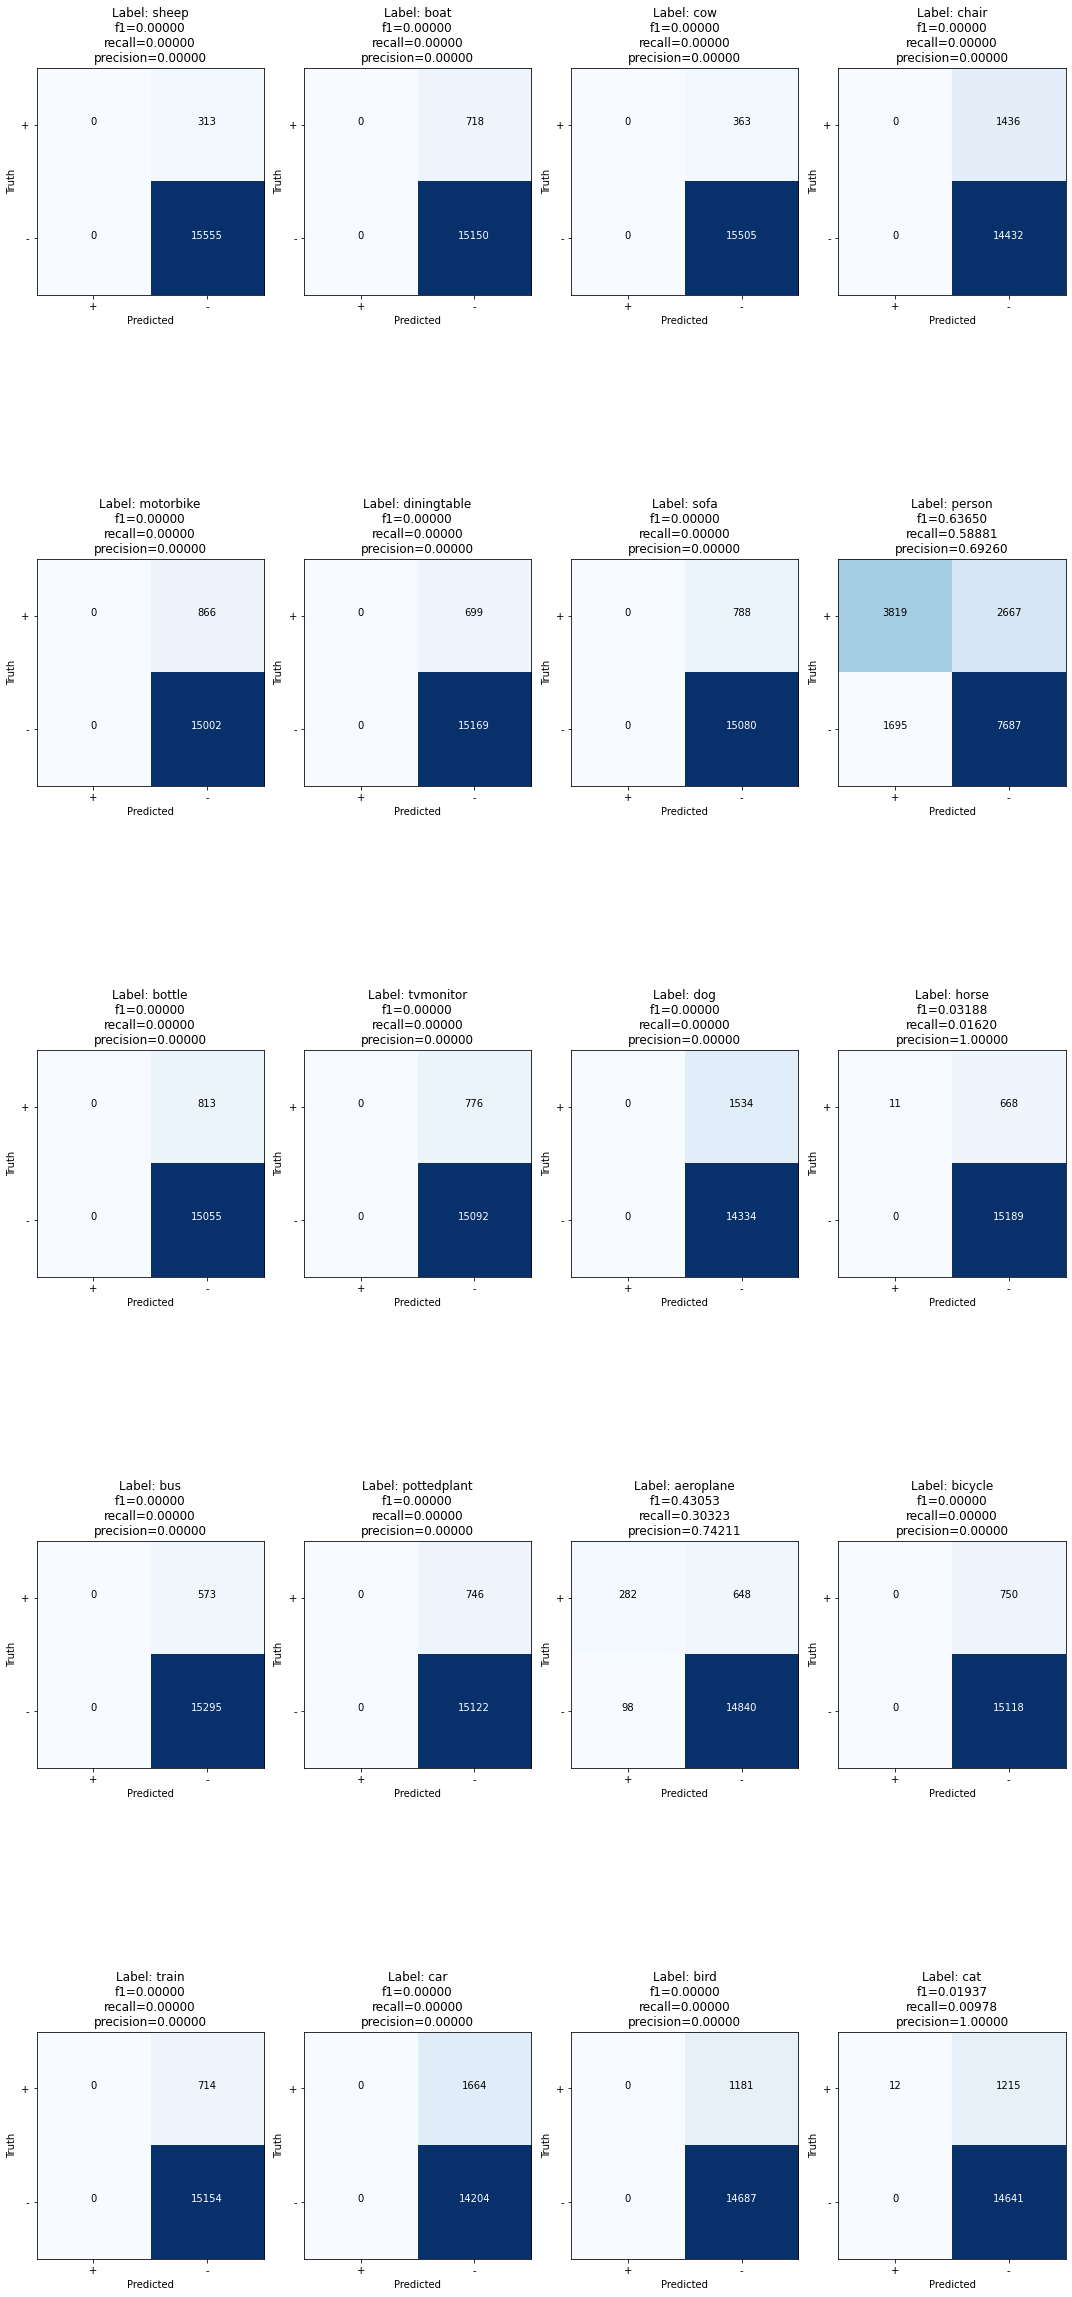

In [0]:
NB_BATCHES = ValidationGenerator.batch_size
THRESH = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(ValidationGenerator, 2)
y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(NB_BATCHES)).astype('int')
y_pred = (model.predict_generator(img_iter_val_1, steps=NB_BATCHES) > THRESH).astype('int')

plot_multiclass_confusion_matrix(y_true, y_pred, object_categories, save_plot=False)

In [0]:
if SAVE_MODEL:
  model.save('MyTrainedModelFinal.h5')  # creates a HDF5 file 'MyTrainedModelFinal.h5'

------------------------------------------------------
### STEP 2.2: Classification Model Using Transfer Learning
------------------------------------------------------
In this section we explore using transfer learning via pre-trained neural network architectures such as VGG16, RESNET50, etc. For this task, we picked InceptionNet V3, given that that it was trained on varied and diverse data (ImageNet), which allows us to apply it to the widely varied dataset of the PASCAL VOC 2009 challenge. It is also a state-of-the-art algorithm in regards to the ImageNet challenge. We use the weights already present in the tensorflow 2.0 documentation to create our model, adjusting only the the final layers so as to match the expected output. The architecture diagram of InceptionNet V3 [1] is taken shown below:

![alt text](https://miro.medium.com/max/1400/1*gqKM5V-uo2sMFFPDS84yJw.png)

In addition, InceptionNet V3 is a very deep architecture, with many convolutional layers alternative with batch normalization and other layers 
which attempt to add an element of attention to the network when training on complex images, as is the case with the complex ImageNet dataset on which it was trained. This is another reason it was picked, as it was a top-performer and state-of-the-art solution in the ImageNet challenge in recent years, thus leading us to believe that it would 
perform well for our problem as well.

In addition, we also considered some other adjustments and improvements to the network choice. The pre-trained network in general is fit to predict up to 1000 classes coming from the ImageNet dataset which can be referenced here.
In general, one needs only add one pooling layer and a full-connected layer to perform predictions into the desired shape of classes. However, we opted for an approach to add further layers in order to better learn the representation extracted from the Inception layers.

Thus, we added a few interconnected layers with decreasing numbers of neurons, interleaved with ReLU activation layers and Batch Normalization layers.
We also added L1 and L2 regularization terms on to these dense fully-connected layers. We also allowed some of the final InceptionNet V3 layers to be trained, or in effect fine-tuned. This fine-tuning of the transfer learning model is to encompass the fact that the distribution of data between ImageNet and PASCAL VOC 2009 is very different, both in data points, and quality of images.

Finally, the class weights of the data were also fed to the compiled model so as to enforce importance of misrepresented classes.
All of this was done with the mindset to minimize overfitting and to help improve validation loss by sacrificing some of our training loss.

As before, we use the F1 score as a metric to evaluate this model instead of accuracy (even categorical accuracy). This is to help account for class imbalance and to account for the distribution of data across the multiple labels/classes as well, since the F1 score is a better metric for this because of its integration of precision and recall scores in its equation.
Thus, it attempts to balance between making correct predictions, and the quality of those predictions. There are of course other metrics worth using for this task, such as Cohen's Kappa, for instance, but this was deemed beyond scope for us.

In terms of loss, it was also deemed to switch from a binary cross-entropy to use a F-measure as a loss. Indeed, this will turn out below to be a good choice for loss function. It does excellent at keeping the learning curves stable. What was noticed in the model from scratch and in experiments with the transfer model, is that the binary cross-entropy loss would lead the network into exploring the weight space too much, and thus led to unstable learning curves.
However, given the nature of our dataset, it was a good choice to use the F-measure as a means to optimize training in imbalanced scenarios.

Naturally, all preprocessing steps were taken within our data generators to ensure that we were producing a model which is accepting valid input to the preprocessing steps. Similar to the model from scratch, random transformations such as rotations, reflections about an axis and so on were done so as to introduce variety into the data.
What also helped in our case was to use random zooming as well. This helped the network focus on various parts of an image as well, which would otherwise be left out due to its size.

[1] Xia, X., Xu, C. and Nan, B., 2017, June. Inception-v3 for flower classification. In 2017 2nd International Conference on Image, Vision and Computing (ICIVC) (pp. 783-787). IEEE.



In [0]:
DO_TRAINING = True
SAVE_MODEL = True
USE_TRAINED = False

Here we fetch our trained model if you as a reader wish to use that instead. Please set parameter USE_TRAINED above to True, and DO_TRAINING to True or False depending on whether your wish to fine-tune (train using transfer learning) or not.

In [0]:
!wget -O MyTransferTrainedModelFinal.h5 https://www.dropbox.com/s/kcoygltyz7pnsg2/MyTransferTrainedModelFinal.h5?dl=0

In [0]:
MyTrainedModel = load_model('MyTransferTrainedModelFinal.h5')

In [0]:
# define the model architecture, input layer, transfer learning architecture, 
# and adjust output shape to 20 via the output layer, with sigmoid activation
# for the multi-label classification task
# train using a binary cross-entropy loss function
from numpy.random import seed
seed(1234)
NB_EPOCHS = 25

TransferModel = Sequential()
f1_metric = F1Metric(ValidationGenerator, 
                     TrainGenerator, 
                     batch_size=ValidationGenerator.batch_size, 
                     train_batch_size=TrainGenerator.batch_size)

def f1_weighted(true, pred): #shapes (batch, 4)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    #predLabels = K.argmax(pred, axis=-1)
    #pred = K.one_hot(predLabels, 4) 


    ground_positives = K.sum(true, axis=0)       # = TP + FN
    pred_positives = K.sum(pred, axis=0)         # = TP + FP
    true_positives = K.sum(true * pred, axis=0)  # = TP
        #all with shape (4,)

    precision = (true_positives + K.epsilon()) / (pred_positives + K.epsilon()) 
    recall = (true_positives + K.epsilon()) / (ground_positives + K.epsilon()) 
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #not sure if this last epsilon is necessary
        #matematically not, but maybe to avoid computational instability
        #still with shape (4,)

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives)
    weighted_f1 = K.sum(weighted_f1)


    return 1 - weighted_f1 #for metrics, return only 'weighted_f1'


InceptionModel = InceptionV3(weights='imagenet', 
                  include_top=False,
                 input_shape=(CLASSIF_IMG_WIDTH, CLASSIF_IMG_HEIGHT, 3))

# add a global spatial average pooling layer
x = InceptionModel.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024,
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(512,
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# and a logistic layer -- let's say we have 20 classes
predictions = Dense(20,
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5))(x)
predictions = Activation('sigmoid')(predictions)


# this is the model we will train
TransferModel = Model(inputs=InceptionModel.input, outputs=predictions )

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in InceptionModel.layers:
    layer.trainable = False
#for i, layer in enumerate(InceptionModel.layers):
#   print(i, layer.name)
for layer in TransferModel.layers[:288]:
   layer.trainable = False
for layer in TransferModel.layers[288:]:
   layer.trainable = True

es = EarlyStopping(monitor='f1_val', patience=5, restore_best_weights=True)

# compile the model (should be done *after* setting layers to non-trainable)
TransferModel.compile(optimizer='rmsprop', loss=f1_weighted)

# work out a good step size for our training and validation sets
STEP_SIZE_TRAIN=TrainGenerator.n//TrainGenerator.batch_size
STEP_SIZE_VALID=ValidationGenerator.n//ValidationGenerator.batch_size
if USE_TRAINED == True:
  TransferModel = MyTrainedTransferModel
  
if DO_TRAINING == True:
  TrainedTransferModel = TransferModel.fit_generator(generator=TrainGenerator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=ValidationGenerator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=(NB_EPOCHS), callbacks = [es, f1_metric],
                      class_weight=model_class_weights)



Epoch 1/70
42/42 [==============================] - ETA: 0s - loss: 752.0991WARNING:tensorflow:Early stopping conditioned on metric `f1_val` which is not available. Available metrics are: loss,val_loss
 — val_f1: 0.514391 — val_precision: 0.530961 — val_recall 0.590592 — train_f1: 0.518691 — train_precision: 0.508902 — train_recall 0.605550
42/42 [==============================] - 132s 3s/step - loss: 752.0991 - val_loss: 1.4931 - f1_val: 0.5144 - precision_val: 0.5310 - recall_val: 0.5906 - f1_train: 0.5187 - precision_train: 0.5089 - recall_train: 0.6055
Epoch 2/70
42/42 [==============================] - ETA: 0s - loss: 602.3813WARNING:tensorflow:Early stopping conditioned on metric `f1_val` which is not available. Available metrics are: loss,val_loss
 — val_f1: 0.553182 — val_precision: 0.516576 — val_recall 0.635287 — train_f1: 0.570004 — train_precision: 0.524983 — train_recall 0.662732
42/42 [==============================] - 148s 4s/step - loss: 602.3813 - val_loss: 1.4394 - f1

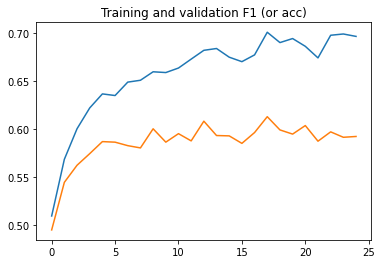

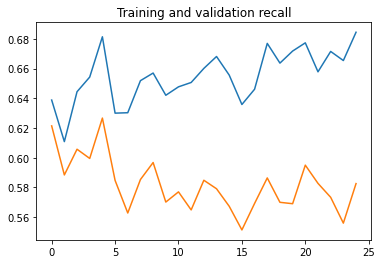

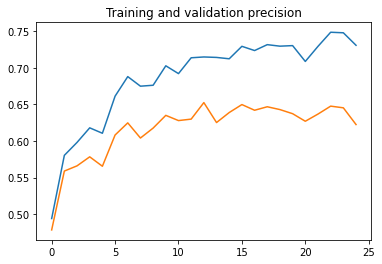

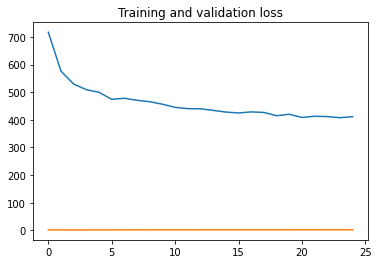

In [0]:
# plot the learning curves (both training and test of our transfer learning model)
plot_model_outcome(TrainedTransferModel)
if SAVE_MODEL == True:
  TransferModel.save('MyTransferModelFinal.h5')  # creates a HDF5 file 'my_model.h5'



Regarding the learning curves, you will note that the validation error/loss is much lower than the training error by orders of magnitude. Rest assured, this is normal behaviour due to the behaviour of the F-measure when using regularization and batch normalization errors. In the technical documentation of Keras, it is noted that this effect is observed.
Indeed, if one scales the validation error by the error measured in layers implementing regularization and batch normalization, the scaling lifts the curve to the level of the training error. In essence it is merely important to note in this case of curves that the errors are convergent rather than diverging, indicating that there is not overfitting taking place, as desired.

In conclusion, with enough training, through many many epochs, a good F1 score of an estimated 0.65 may be obtained, which is good on this dataset according to literature. Given more data through data augmentation and addition of further VOC data sources such as the VOC PASCAL 2012 dataset, better results can be obtained.

Below we will plot confusion matrices on a class-by-class basis (i.e. as one-vs-all other classes) to diagnose the model's strenths and weaknesses.

In [0]:
NB_BATCHES = ValidationGenerator.batch_size
THRESH = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(ValidationGenerator, 2)
y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(NB_BATCHES)).astype('int')
y_pred = (TransferModel.predict_generator(img_iter_val_1, steps=NB_BATCHES) > THRESH).astype('int')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


Instructions for updating:
Please use Model.predict, which supports generators.


Here we plot the confusion matrices which result from a one-vs-all analysis of each predicted category. This lets us do a diagnostic as to what the model is predicting and where it's weak points are, in a similar vein to what was done for STEP 2.1 for the classification model from scratch.

We see very good results for the model with transfer learning. Specifically, it scores over 3 times higher on the F-measure/F1 score implemented as a training metric and loss function, with a final score of 0.62 on F1, and similar values for both precision and recall. We can see how this varies between classes, and indeed what this does is confirm our suspicions that our classification model from scratch, while simple and not very deep, can with enough training samples arrive at a better score. Indeed, it seems that the transfer learning model confirms to us that the worst performing classes are those which are minority classes, where there are more false positives and false negatives present (i.e. misclassifications). 

The primary reason for this is not only class imbalance, considering we are using a pre-trained net, but also because the pre-trained weights were trained on ImageNet, and generally sees much better performance when used in conjunction with other datasets such as the VGGFace data for facial feature extraction, as in the first group assignment of this course. Additionally, the multi-label aspect of this task means that the network is also trained to give attention to one object in the scene, meaning that images where there are many objects tend to suffer more, as we shall see below via an example.

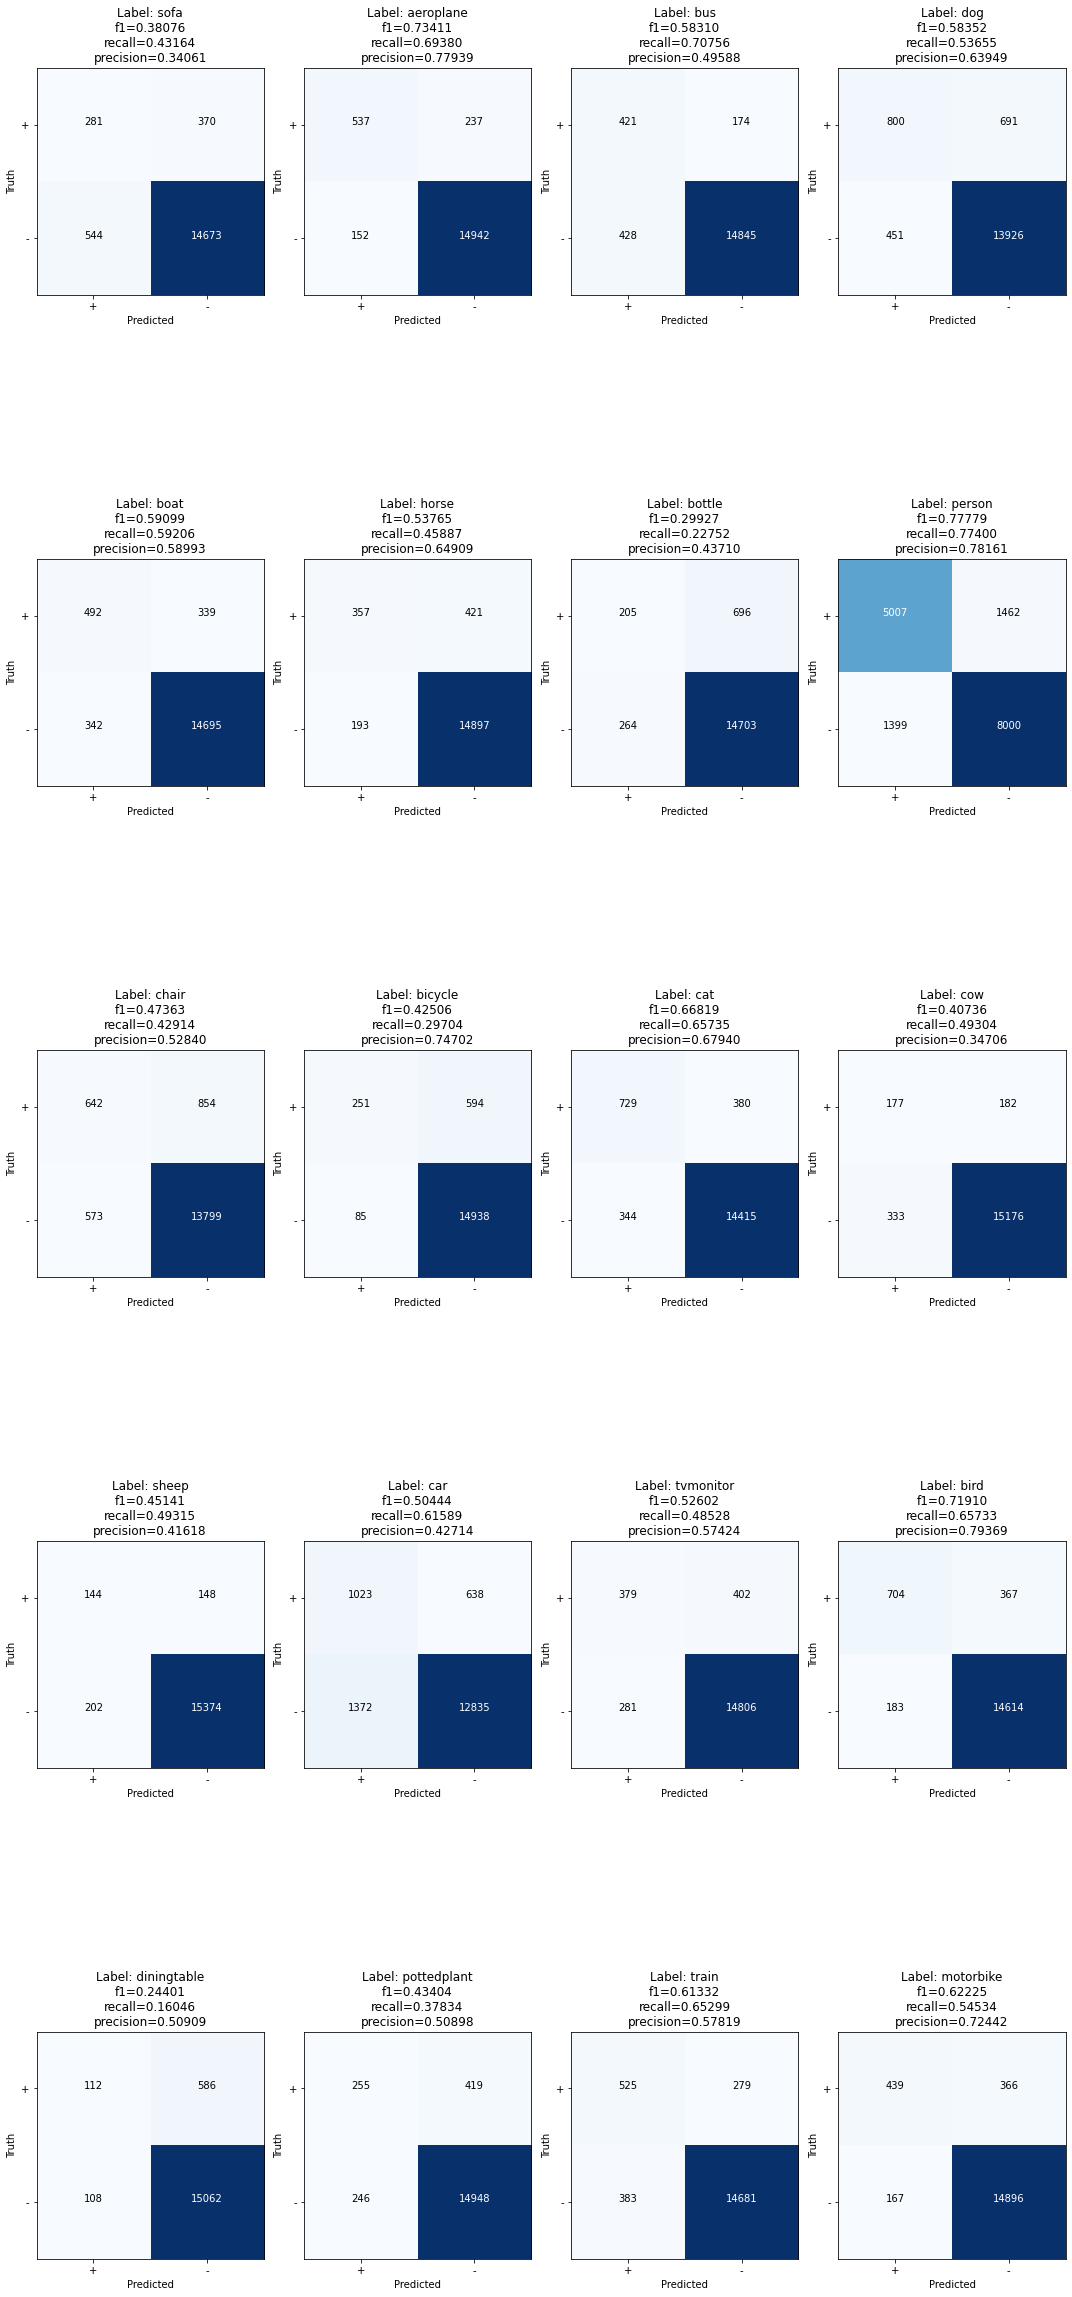

In [0]:
plot_multiclass_confusion_matrix(y_true, y_pred, object_categories, save_plot=False)

In short what we see in the above confusion matrix is that we are focusing heavily on doing well in classifyin majority classes where there are enough samples: People, Dogs and Cats and even Cars are well-performing categories with a high F1 score, precision score and recall score, and these are the majority classes as seen in our class distribution plotted in STEP 1.2. Other classes suffer from many misclassifications as mentioned above. 

One other insight actually comes from ImageNet itself, on their ImageNet search engine, where you can view example images from the data along with the data hierarchy. Our model performs poorly on "Potted-Plants", even though plants are a prevalent feature in the ImageNet dataset, as one can see here via this link. However, in comparison to the PASCAL VOC 2009 data where the plants feature prominent plants, the ImageNet data focuses primarily on plant features such as leaves, flowers and so on.

---
### STEP 2.3 Final Remarks
---

In conclusion, training a model from scratch is a challenging procedure. There is a reason this is an active field of study. Training a classification model especially on the PASCAL VOC 2009 data was a challenge in many regards do the sparse features in many of the images, for example as mentioned before, the obscurement of various subjects of interest in a scene being examined, or because of the low numbers of data points available for some of the labels. Even if other steps were implemented, such as introducing a different loss function such as the F-measure loss defined for the transfer learning fine-tuning or introducing batch normalization and L1/L2-regularization into the network, the issue of training samples and quality of data quickly becomes an issue due to the large numbers of trainable parameters that then need to be adjusted and accounted for in training procedures.

This is luckily where transfer learning came in handy. By using the InceptionNet V3 architecture, trained on ImageNet data, one can achieve very good performance. However, simply due to the different in quality of images, the different distribution of classes which nevertheless needs to be fine-tuned against in our transfer learning approach ahd due the the large inter- and intra-class imbalances, we see that the transfer learning model suffers many of the same weaknesses in focusing on People, Dogs, Cats and suffering on classes which are minor such as Sheep, but also on classes which don't resemble seen examples very well, such as Potted-Plants, in a similar way that the model from scratch does. The difference is that this model is usable and can still generate good operational performance for certain applications.

In future, we recommend applying other more advanced networks that implement more robust attention layers such as RCNN and other methods for encorporating bounding boxes.

We also recommend augmenting the data by adding more training examples through similar sourcse such as PASCAL VOC 2012 and other years of the PASCAL VOC data challenge.

Finally, using a subsample of the 20 classes (for example, reducing the problem to only Dogs, Cats and People) can help produce a much more usable model. This was out of scope for this project though, since we focused on the full multi-label classification task, without bounding boxes.


------------------------------------------------------
## STEP 3: Segmentation
------------------------------------------------------

In this section, we implemented a model from the scratch for semantic segmentation. The goal of this task is to segment an image based on its consituent parts, for example, into a person, dog, cat, car, etc. We then want to show this as a labelled representation. 

For this section, we use the output as IMG_HEIGHT x IMG_WIDTH x CLASSES, where we have 21 classes. Thus, we use 21 masks (one for background). This is done since most architectures predict map-level outputs, one map for each mask, rather than pixel-by-pixel. This then becomes a multi-class problem in many respects.

------------------------------------------------------
### STEP 3.1: Semantic segmentation from Scratch
------------------------------------------------------

#### STEP 3.1.1: Data preparation




We need to map each colored pixel to it's label value. For that reason, we need a mapping from colors to label. We will use this map also from converting our labeled pixels back to original colors after predicting a mask.

In [0]:
Map = {
    (0, 0, 0): 0,  # background
    (128, 0, 0): 1,  # aeroplane
    (0, 128, 0): 2,  # bicycle
    (128, 128, 0): 3,  # bird
    (0, 0, 128): 4,  # boat
    (128, 0, 128): 5,  # bottle
    (0, 128, 128): 6,  # bus
    (128, 128, 128): 7,  # car
    (64, 0, 0): 8,  # cat
    (192, 0, 0): 9,  # chair
    (64, 128, 0): 10,  # cow
    (192, 128, 0): 11,  # diningtable
    (64, 0, 128): 12,  # dog
    (192, 0, 128): 13,  # horse
    (64, 128, 128): 14,  # motorbike
    (192, 128, 128): 15,  # person
    (0, 64, 0): 16,  # pottedplant
    (128, 64, 0): 17,  # sheep
    (0, 192, 0): 18,  # sofa
    (128, 192, 0): 19,  # train
    (0, 64, 128): 20,  # tvmonitor
}

Now we need a datagenerator class to generate data. The data generator class maps each color of the mask to it's label. Images are also normalized by using division operator. Since, we are using cross_entropy as our loss function, it requires that data has one-hot encoding.

In [0]:
class DataGen(keras.utils.Sequence):   
    def __init__(self, ids, path, batch_size=8, image_size=256):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.crop_size = image_size
    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std
        
    def __load__(self, id_name):
           ## Path
        image_path = os.path.join(self.path, "JPEGImages", id_name)
        label_name = id_name.split(".")[0]
        label_name = label_name+".png"
        mask_path = os.path.join(self.path, "SegmentationClass", label_name)
        
        ## Reading Image and mask
        image = cv2.imread(image_path, -1)
        label = cv2.imread(mask_path, -1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256,256))
        label = cv2.resize(label, (256,256))
        channels = []
        one_hot_map = []
        for color, label_id in Map.items():
            class_map = tf.reduce_all(tf.equal(label, color), axis=-1)
            one_hot_map.append(class_map)
        one_hot_map = tf.stack(one_hot_map, axis=-1)
        one_hot_map = tf.cast(one_hot_map, tf.float32)
        image = np.float32(image) / 127.5 - 1
        return image,one_hot_map.numpy()
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
        image = np.array(image)
        mask  = np.array(mask)
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

Next, we define our training and validation dataset. In our case, we used $30\%$ of the total data for validation. Very few images are used as testing datapoints.

In [0]:
training_labels_path = os.path.join(voc_root_folder, 'SegmentationClass')
training_data_path =  os.path.join(voc_root_folder, 'JPEGImages')

training_labels  = next(os.walk(training_labels_path))[2]
full_training_data= next(os.walk(training_data_path))[2]
training_ids = []
for i in range(len(training_labels)):
    splitted = training_labels[i].split(".")[0]
    jpeg_format = splitted+".jpg"
    if(jpeg_format in full_training_data):
       training_ids.append(jpeg_format)
val_data_size = int(0.3*(len(training_ids)))
test_data_points = 20
validation_ids = training_ids[:val_data_size]
training_ids = training_ids[val_data_size:]
testing_ids = training_ids[:20]
training_labels = training_labels[val_data_size:]
assert len(training_ids) == len(training_labels)
for i in range(len(training_labels)):
    assert(training_labels[i].split(".")[0]+".jpg" == training_ids[i])

#### STEP 3.1.2: Building FCN8


In the next section, we start importing few layers that we need to build our FCN-8 model.

In [0]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Input, Cropping2D, add, Dropout, Reshape, Activation
from keras import optimizers
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model
from keras.layers import Input,Conv2D,ZeroPadding2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,Add, BatchNormalization,Activation,Lambda
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.constraints import max_norm
from tensorflow.keras import regularizers
regularizer_l2=regularizers.l2
from keras.layers import LeakyReLU
metrics = tf.keras.metrics
import requests
import zipfile



Here, we define the settings for our model. This includes channels number, number of classes, what metrics we will use, size of the input images and also batch size.

In [0]:
IMAGE_ORDERING = 'channels_first'
MERGE_AXIS = 1
n_classes = 22
load_weights = True
metrics = tf.keras.metrics
batch_size = 20
image_size = 256
imshape = (256, 256, 3)

The models(FCN-8 and U-net) were trained from the sratch. We saved their weights so that we can re-use them as it is very time consuming process to train a deep neural network. We need to download these weights:

In [0]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

We initiate downloading by using a google drive api.

In [0]:
share_able_link = "19D2kNEjSHQdMHt14RF1TQdfWdvDnie5E"
destination  = "fcn_weights.h5"
download_file_from_google_drive(share_able_link, destination)
id_unet = "1F550kl0__epuvis6NAOPXyYcMlONWklN"
destination  = "unet_weights.h5"
download_file_from_google_drive(id_unet, destination)

We finally build the FCN-8 architecture. The model defined in the next section, is a classical FCN-8 model and there were no changes brought. We have also two skip connections and used 8x upsmapling as it is done in original paper of FCN-8. As an activation function, we are using leakyRelu layers. We also used other type of regulizers during training, which include kernel_regulize with l1 and l2 norms. 

In [0]:
def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.8), kernel_regularizer='l1',padding='same',name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.8),kernel_regularizer='l1', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.8),padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.8),kernel_regularizer='l1',padding='same',name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.8),padding='same',name='block3_conv1',data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.8), kernel_regularizer='l1',padding='same',name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.7), padding='same',name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation=LeakyReLU(alpha=0.6),kernel_regularizer='l1', padding='same',name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation=LeakyReLU(alpha=0.6),padding='same',name='block4_conv2',data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation=LeakyReLU(alpha=0.6),padding='same',name='block4_conv3',data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='elu', kernel_regularizer='l1',padding='same',name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='elu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='elu',padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)


    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='elu', padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='elu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='elu', padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation=LeakyReLU(alpha=0.45) , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)
    if(load_weights):
       model.load_weights('/content/fcn_weights.h5')
    return model


We did not build only one model but also unet was built and trained from scratch. In the next section we build U-Net model.
There are few conflicts between layers of unet and FCN-8, so we have re-import many things for unet.

In [0]:
import cv2
import numpy as np
from skimage import io
from lxml import etree
from skimage.transform import resize
import os
from sklearn.model_selection import train_test_split
import math
import os
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.layers import Input,Conv2D,ZeroPadding2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,Add, BatchNormalization,Activation,Lambda
from keras.models import Model, load_model
from keras.layers import Dropout,Flatten,Reshape,concatenate,Dense,add
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical

from types import MethodType
nb_classes = 22
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Input, Cropping2D, add, Dropout, Reshape, Activation
from keras import regularizers
from keras.constraints import max_norm
from tensorflow.keras import regularizers
regularizer_l2=regularizers.l2
IMAGE_ORDERING = 'channels_first'
MERGE_AXIS = 1
nb_classes = 22
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


We also built unet model for testing and comparing it's results with FCN8. For U-Net, we also follow the original architecture. In trasfer learning section, we also used u-net. Transfer learning section also includes an image which shows U-Net architecture. We have 3 skips connection in unet model as compared to FCN-8 where we have only 2 skips connections. For activation function, we used elu, as from the initial experiments we found that elu works better than Relu activation. For the regulization purpose, we relied on l1 norm as it performed better than any other kernel.

In [0]:
n_classes = 22
def unet(pretrained=False, base=4):

    if n_classes == 1:
        loss = 'binary_crossentropy'
        final_act = 'sigmoid'
    elif n_classes > 1:
        loss = 'categorical_crossentropy'
        final_act = 'softmax'

    b = base
    i = Input((imshape[0], imshape[1], imshape[2]))

    c1 = Conv2D(2**b, (3, 3), activation='elu',kernel_regularizer='l1', kernel_initializer='he_normal', padding='same') (i)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(2**b, (3, 3), activation='elu',kernel_regularizer='l1', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_regularizer='l1',kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(2**(b+1), (3, 3), activation='elu',kernel_regularizer='l1', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(2**(b+2), (3, 3), activation='elu',kernel_regularizer='l1', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(2**(b+3), (3, 3), activation='elu',kernel_regularizer='l1', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(2**(b+4), (3, 3), activation='elu',kernel_regularizer='l1', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(2**(b+4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(2**(b+3), (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(2**(b+3), (3, 3), activation='elu',kernel_regularizer='l1', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_regularizer='l1',kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(2**(b+2), (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(2**(b+2), (3, 3), activation='elu',kernel_regularizer='l1', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(2**(b+1), (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(2**(b+1), (3, 3), activation='elu',kernel_regularizer='l1', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_regularizer='l1',kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(2**b, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    o = Conv2D(n_classes, (1, 1), activation=final_act) (c9)
 
    model = Model(inputs=i, outputs=o, name="unet")
    if(load_weights):
       model.load_weights('/content/unet_weights.h5')
    return model

Since we have two different model. To test the model, one can easily select the model name and the results will be generated. As the purpose of this section is to make our app user-friendly.


In [0]:
#model = FCN or unet
select_model = "FCN"

In [0]:
if select_model == "FCN":
   model = FCN8(22,256,256)
else:
   model = unet()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


After choosing the model, we need to compile it. This section compiles the model and shows it's architecture as summary. We used categorical cross  entropy as loss function and categorica_accuracy as metric.

In [0]:
sgd = optimizers.SGD(lr=1E-4, decay=5**(-4), momentum=0.9, nesterov=True)
adam = Adam(lr=1e-4)
acc = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

model.compile(
    loss="categorical_crossentropy",
    optimizer=sgd,
    metrics=[acc])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

As it was not possible to load all the data once into the memory, we used data generators for this purpose. Next section, define the instances of the data generator.



In [0]:
train_gen = DataGen(training_ids, voc_root_folder, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(validation_ids, voc_root_folder, image_size=image_size, batch_size=batch_size)

train_steps = len(training_ids)//batch_size
valid_steps = len(validation_ids)//batch_size
num_epochs = 600


#save_weight = keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/weights/weight.h5',save_weights_only=True)

Since, we are using weights that we obtained by training the models from the sratch, we can either use those weights or we can train from the sratch. Next section provides an option to choose one of these two:

In [0]:
fit_seg_model = False

In [0]:
if(fit_seg_model):
   history = model.fit_generator(generator=train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=train_steps,
                    validation_steps=valid_steps,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=[])

We can save weights so that we don't train the model again and again from scratch as it take too much time.

In [0]:
#model.save_weights('/content/drive/My Drive/weights/my_model_weighteds.h5')

We now define few functions that will reconstruct the predict image into the original colored image.

In [0]:
def reconstruct(pred):
  image = np.zeros((256,256,3),dtype=np.uint8)
  pred = np.expand_dims(pred,axis=-1)
  for color, label in Map.items():
      for i in range(256):
        for j in range(256):
          if(int(pred[i,j]) == label):
             image[i,j] = color
  image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
  return (image,str(Counter(pred.flatten())))

This function predicts and reconstructs the image.

In [0]:
def get_predicted_picture(x):
   pred_image = model.predict(x)
   pred_image = np.squeeze(pred_image,axis=0)
   pred = np.argmax(pred_image,axis=-1)
   (image,classes) = reconstruct(pred)
   return (image,classes)

Defines, how many images we want to predict from validation set.

In [0]:
number_of_images_to_test = 20

The following function is used to plot the images.

In [0]:
def plot_images(list_of_images,rows):
    fig = plt.figure(figsize=(30., 30.))
    grid = ImageGrid(fig, 111, 
                 nrows_ncols=(rows,8), 
                 axes_pad=0.1,  
                 )

    for ax, im in zip(grid, list_of_images):
        ax.imshow(im)

    plt.show()
 


Based on the number of chosen images from validation set, we start predicting and reconstructing the images.

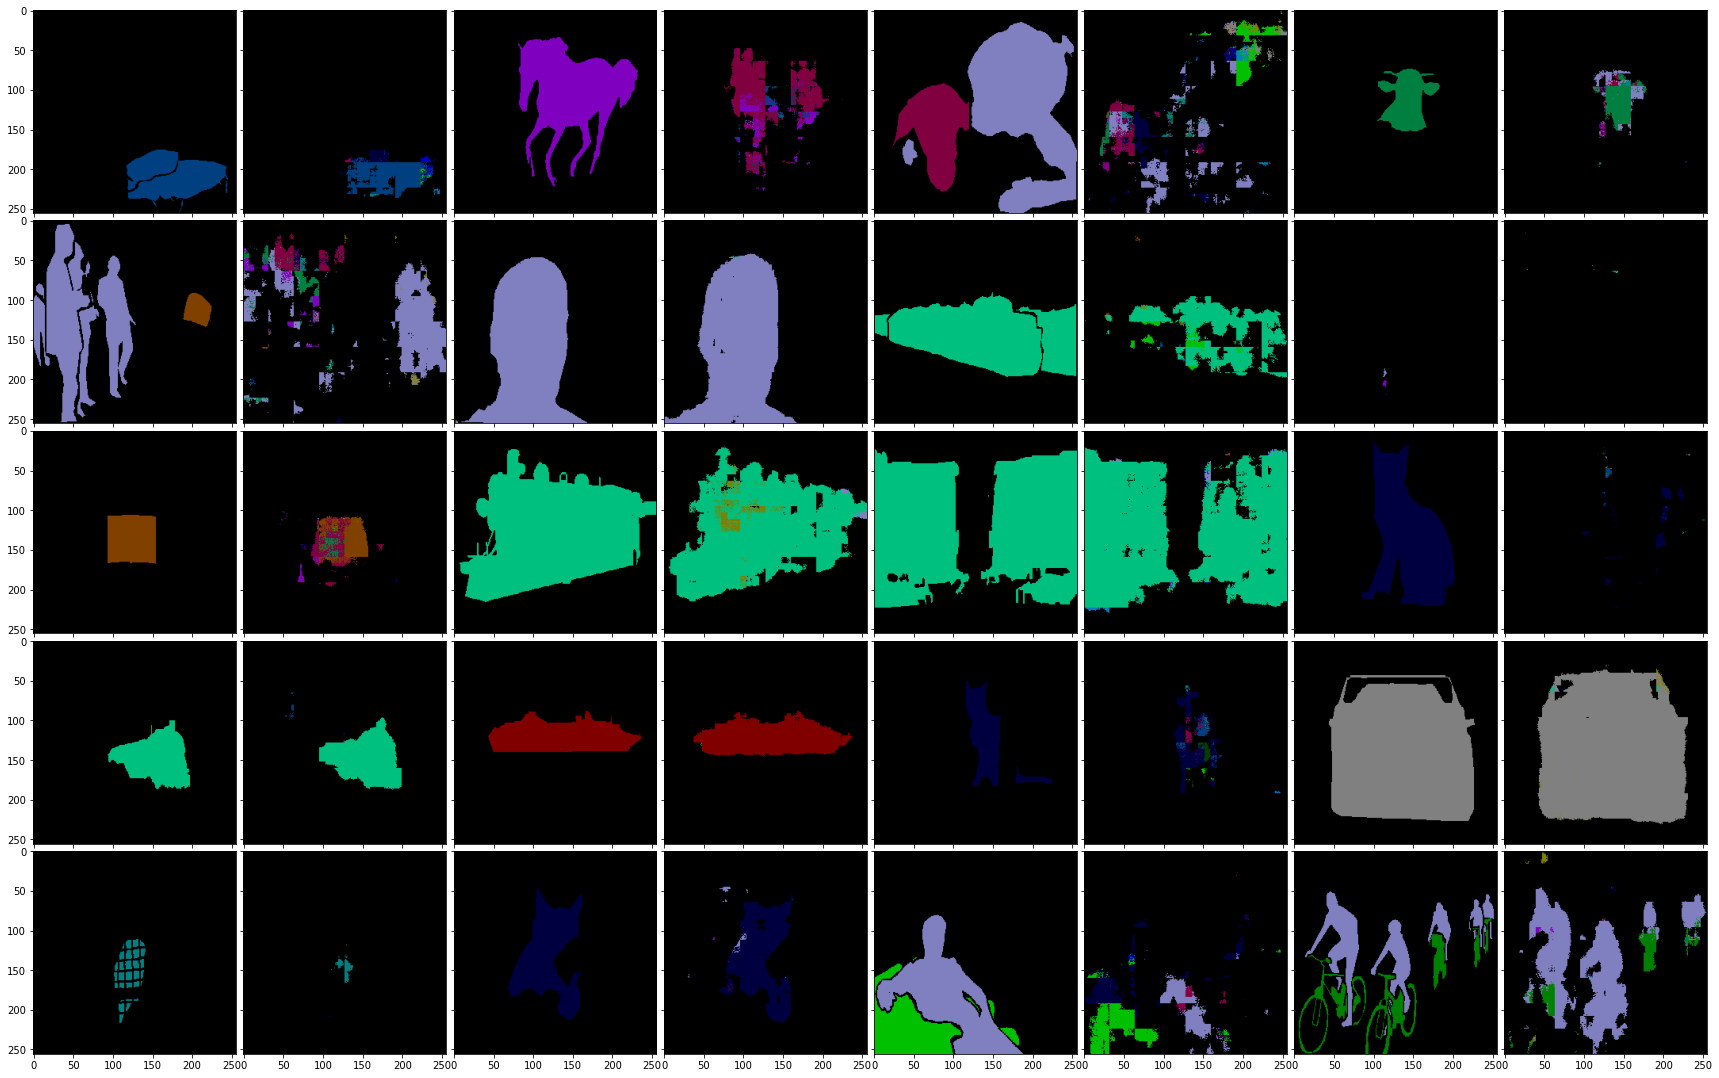

In [0]:
valid_gen = DataGen(validation_ids, voc_root_folder, image_size=image_size, batch_size=1)
list_of_images = []

for i in range(number_of_images_to_test):
    x,y = valid_gen.__getitem__(i)
    (image,classes) = get_predicted_picture(x)
    y = np.squeeze(y,axis=0)
    y =  np.argmax(y,axis=-1)
    (y,classes) = reconstruct(y)
    list_of_images.append(y.copy())
    list_of_images.append(image.copy())

tota_images = number_of_images_to_test*2
rows = math.ceil(tota_images/8)
plot_images(list_of_images,rows)


We extracted some random images from google which are not part of Pascal voc dataset to check our models. Here we download those images from google  drive to see the performance/ or to use as test set.

In [0]:
share_able_link = "1ZCBzzawy-eNwYtn6psEp3WRFwEH_cJA0"
destination  = "random_image.zip"
download_file_from_google_drive(share_able_link, destination)
with zipfile.ZipFile('/content/random_image.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/random/')

Collect all the images in the repository

In [0]:
random_images = os.path.join('/content/random')
random_img_name  = next(os.walk(random_images))[2]

Now we read those random/test images into a list for the test purpose.

In [0]:
list_of_test_mages = []
for i in range(len(random_img_name)):
    img_name = random_img_name[i]
    image = cv2.imread('/content/random/'+img_name)
    image = cv2.resize(image,(256,256))
    list_of_test_mages.append(image.copy())

Now we try segmentation on these test images.

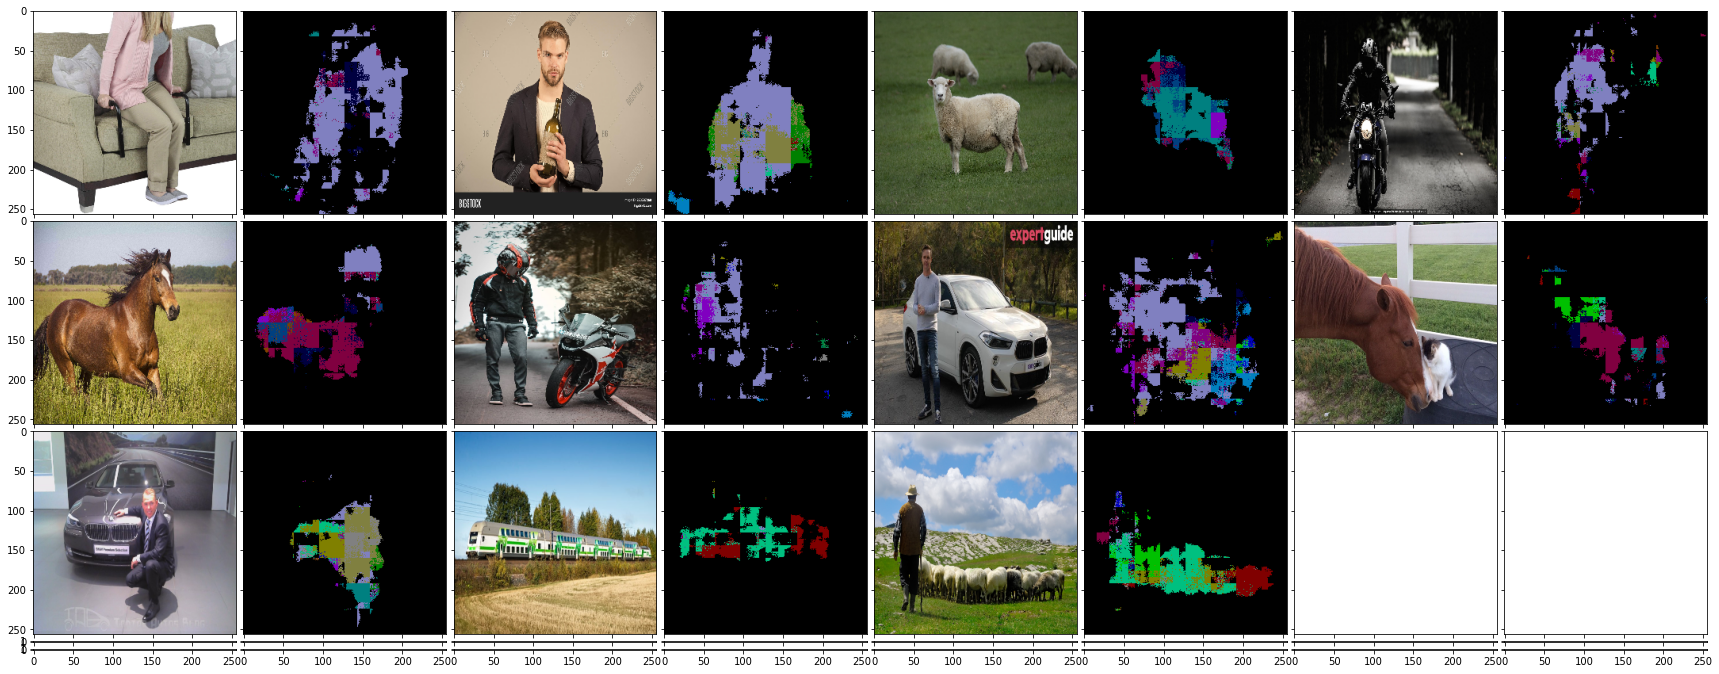

In [0]:
list_to_print = []
for i in range(len(list_of_test_mages)):
    image = cv2.cvtColor(list_of_test_mages[i],cv2.COLOR_BGR2RGB)
    img = np.float32(image) / 127.5 - 1
    img = np.expand_dims(img,axis=0)
    (image,classes) = get_predicted_picture(img)
    list_to_print.append(cv2.cvtColor(list_of_test_mages[i],cv2.COLOR_BGR2RGB))
    list_to_print.append(image)
tota_images = number_of_images_to_test*2
rows = math.ceil(tota_images/8)
plot_images(list_to_print,rows)

------------------------------------------------------
### STEP 3.2: U-Net Segmentation Model with Transfer Learning
------------------------------------------------------

To implement transfer learning for the segmentation model, we adapt the U-Net [2] implementation to incorporate a different 'encoder' portion of the network. We take again a ResNet50 model trained on ImageNet as this encoder portion of the network (see diagram below)
![alt text](https://miro.medium.com/max/1400/1*OkUrpDD6I0FpugA_bbYBJQ.png)

In this network architecture illustrated in Fig. 1. We insert ResNet50 as the pre-trained network for transfer learning up until the last convolutional layer. We also make sure to remove any flatten layers from the defined ResNet50 network model. The reason for choosing ResNet50 is that again, this is trained on similar data ImageNet, and hence has similar weights. Additionally, InceptionNet V3, which was used in the classification section, is not available as a backbone for the UNet architecture provided by the segmentation-models package for Keras.

Below, we define a loss function and its corresponding metric to train and evaluate the segmentation model. These are the Dice loss coefficient, and the Dice metric. Also in experiments, the IoU loss function is used and also implemented in the final transfer learning model when performing fine-tuning of the weights and decoder layer.

[2] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C.W. and Heng, P.A., 2018. H-DenseUNet: hybrid densely connected UNet for liver and tumor segmentation from CT volumes. IEEE transactions on medical imaging, 37(12), pp.2663-2674.

What is a Dice loss and IoU loss and how do they help in segmentation? The Intersection over Union (IoU) metric is a method to measure the percent overlap between the target mask and our prediction output. This metric is closely related to the Dice loss/coefficient which is often used as a loss function during training. In other words the IoU metric measures the number of pixels common between the target and prediction masks divided by the total number of pixels present across both masks. This is helpful for segmentation as it will mitigate pixel coarseness and provide better segments and sets to be used in the final output. For example, rather than having disjoint pixels in the output, this loss/metric encourages a model to be strict in maintaining set coherence


In [0]:
# define the model architecture, input layer, transfer learning architecture, 
# and adjust output shape to 20 via the output layer, with sigmoid activation
# for the multi-label classification task
# train using a binary cross-entropy loss function
smooth = 1.


# Define IoU metric
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)



Load the weights that we got after fine-tuning on the pre-trained model.

In [0]:
share_able_link = "1--ZO1bl0WjhQ6CG5gvQXSUqhDS6idEpj"
destination  = "transfer_seg_Weights.h5"
download_file_from_google_drive(share_able_link, destination)

In [0]:
DO_TRAINING = True
SAVE_MODEL = True
USE_TRAINED = True

In [0]:
!wget -O MyTransferSegmentationModelFinal.h5 https://www.dropbox.com/s/rt0gauvx683m8p4/MyTransferSegmentationModelFinal.h5?dl=0

In [0]:
MyTransferSegmentationModelFinal = load_model('/content/MyTransferSegmentationModelFinal.h5')

In [0]:
# define the backbone architecture to use
BACKBONE = 'resnet34'

# preprocess input
#x_train = preprocess_input(x_train)
#x_val = preprocess_input(x_val)
NB_CLASSES = 21
BATCH_SIZE = 32
IMAGE_SIZE = 128
NUM_EPOCHS = 50

# define model
model = sm.Unet(BACKBONE, classes=NB_CLASSES, encoder_weights='imagenet', encoder_freeze=False)
if USE_TRAINED:
  model.load_weights('/content/transfer_seg_Weights.h5')
  

model.compile(
    'Adam',
    loss=sm.losses.categorical_focal_dice_loss,
    metrics=[sm.metrics.iou_score],
)

train_gen = DataGen(training_ids, voc_root_folder, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
valid_gen = DataGen(validation_ids, voc_root_folder, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
STEP_SIZE_TRAIN = len(training_ids)//BATCH_SIZE
STEP_SIZE_VALID = len(validation_ids)//BATCH_SIZE
#STEP_SIZE_TRAIN=TrainGenerator.n//TrainGenerator.batch_size
#STEP_SIZE_VALID=ValidationGenerator.n//ValidationGenerator.batch_size

if USE_TRAINED:
  model = MyTransferSegmentationModelFinal
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
if(DO_TRAINING):
   segmentation_history = model.fit_generator(train_gen, 
                    validation_data=valid_gen, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_steps=STEP_SIZE_VALID, 
                    epochs=(NUM_EPOCHS))

85524480/85521592 [==============================] - 3s 0us/step
Epoch 1/200


Here we predict again on random dataset.

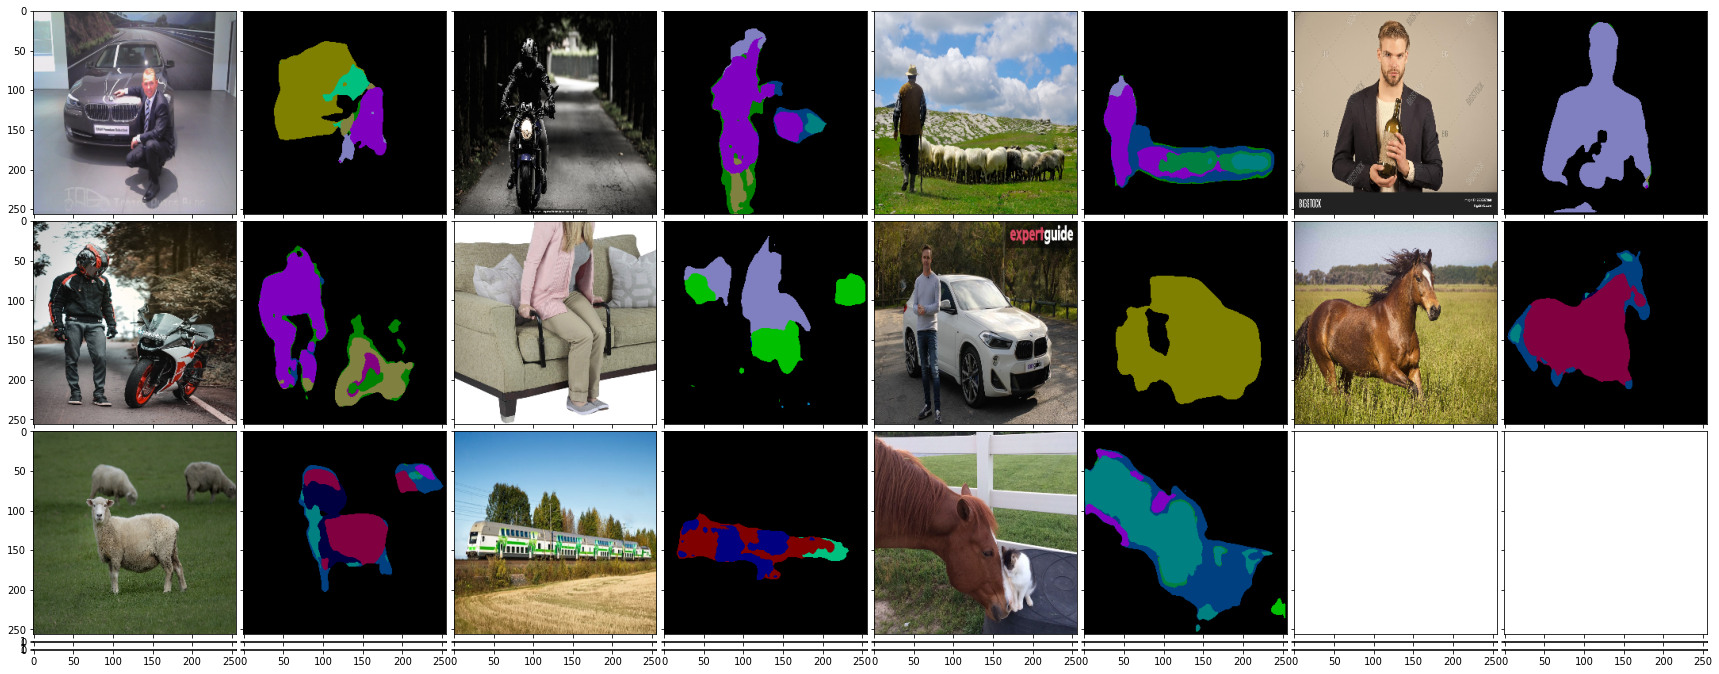

In [0]:
list_to_print = []
for i in range(len(list_of_test_mages)):
    image = cv2.cvtColor(list_of_test_mages[i],cv2.COLOR_BGR2RGB)
    img = np.float32(image) / 127.5 - 1
    img = np.expand_dims(img,axis=0)
    (image,classes) = get_predicted_picture(img)
    list_to_print.append(cv2.cvtColor(list_of_test_mages[i],cv2.COLOR_BGR2RGB))
    list_to_print.append(image)
tota_images = number_of_images_to_test*2
rows = math.ceil(tota_images/8)
plot_images(list_to_print,rows)

In [0]:
if SAVE_MODEL:
  model.save('MyTransferSegmentationModelFinal.h5')  # creates a HDF5 file 'my_model.h5'

---
## STEP 4: Adversarial Attacks on Classification Models
---
In this section we explore the task of adversarial attacks on trained classification models.

In an adversarial attack, an adversary (attacker) adds noise (perturbation) to an image in an
attempt to fool the system under attack.

In this exercise, we implement an encoder-decoder style adversary, which aims to generate input to fool our pre-trained classification model.

We use our pre-trained transfer learning model as opposed to the model trained from scratch in order to illustrate the strong effects adversarial training can have. This will be more evident in the transfer learning model, as the performance there is substantially better than the model built from scratch.

---
### STEP 4.1: Data Preparation and Custom Losses
---

Here we define a custom loss function which is the negative of the usual categorical cross-entropy function. The reason for selecting categorical cross-entropy instead of binary cross-entropy is that we also want to penalize loss across all other classes (we do not want the adversary to allow the model to guess many different classes, one of which being the correct class potentially).

Here we use the negative of the usual loss so as to optimize incorrect classifications for the adversary. We add this to the Keras state dictionary for training later.


In [0]:
#custom activation function for keeping adversarial pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})


Here we do the all important step of loading our pre-trained transfer learning model. We do this since the last few layers are custom-trained and hence the weights need to be saved regardless of using a pre-trained network.

In [0]:
!wget -O MyTransferTrainedModelFinal.h5 https://www.dropbox.com/s/kcoygltyz7pnsg2/MyTransferTrainedModelFinal.h5?dl=0

--2020-06-01 20:22:16--  https://www.dropbox.com/s/kcoygltyz7pnsg2/MyTransferTrainedModelFinal.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/kcoygltyz7pnsg2/MyTransferTrainedModelFinal.h5 [following]
--2020-06-01 20:22:17--  https://www.dropbox.com/s/raw/kcoygltyz7pnsg2/MyTransferTrainedModelFinal.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc11c2e39131a717da8cbce241d2.dl.dropboxusercontent.com/cd/0/inline/A40IxPuGmdgL89vokXmJbwi1dRTY-f3gKGOYQO8EonRJXy7ElAiiGepZ_AaPU29h0cDaoNeHPRaTKTiiZNGLvv9pv3HrzStHvJ8ICxELYTVhqx93OD_GdLN-iZiutJ6cyzw/file# [following]
--2020-06-01 20:22:17--  https://uc11c2e39131a717da8cbce241d2.dl.dropboxusercontent.com/cd/0/inline/A40IxPuGmdgL89vokXmJbwi1dRTY-f3gKGOYQO8EonRJXy7ElAii

In [0]:
MyTransferModel = load_model('MyTransferTrainedModelFinal.h5')

---
### STEP 4.2: Adversarial training against a classification model
---

In this part we being training our adversary. The way the adversary is defined is in the style of a normal auto-encoder. We use a simple but effective two layer normally initialized noise layer which learns how to add noise to the an image before feeding it as input to our pre-trained classification transfer learning model.

The layers for the pre-trained model are frozen so as to not induce training which may learn the noise in the images. 

The adversary is then trained with some regularization terms to ensure that the noise layers remain as noise, instead of trivially destroying the image, preventing it from being discernible to the naked eye, and with a negative binary cross-entropy loss function defined prior.

In [0]:
example_image = cv2.imread('/content/VOCdevkit/VOC2009/JPEGImages/2007_006163.jpg') # reads image 'opencv-logo.png' as grayscale
example_image = cv2.resize(example_image, (CLASSIF_IMG_HEIGHT, CLASSIF_IMG_WIDTH))
cv2_imshow(example_image) # 2008_007327

We are careful to adhere to all the norms of preprocessing and reshaping input

In [0]:
example_image = np.reshape(example_image, (-1, example_image.shape[0], example_image.shape[1], example_image.shape[2]))
preprocessed_example = inception_preprocess_input(example_image)
prediction_example = MyTransferModel.predict(preprocessed_example)

THRESH = 0.5
prediction_example = (prediction_example  > THRESH).astype('int')
prediction_example = prediction_example[0]


The output prediction is of course a person

In [0]:
array_to_labels(prediction_example, object_categories)

This is the desired target we want the adversary to fool our classifier with if the image is, say a Person (target = 9), we may want to fool our model into thinking it is a Horse (target = 5). 

The way we do this is by freezing our model's weights, and by using the output of the model in combination with Gaussian noise, which is added to the image via a fully-connected layer of shape IMG_HEIGHT x IMG_WIDTH x CHANNELS to pollute the image in a clever way. We train with the negative cross-entropy defined above and hope to arrive at a good spoof

In [0]:
# this is the desired target we want the adversary to fool our classifier with
# if the image is, say a Person (target = 9), we may want to fool our model
# into thinking it is a Dog (target = 15).
TARGET = 5
IMAGE_SIZE = 150
NB_EPOCHS = 10000
THRESH = 0.5
#function for generating an adversarial example given a base image, adversarial class target, classifier, and regularization type
def generate_adversary(img,target,model,regularization,loss_function):
    
    #input for base image
    image = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3),name='image')
    #unit input for adversarial noise
    one = Input(shape=(1,),name='unity')
    
    #layer for learning adversarial noise to apply to image
    noise = Dense(IMAGE_SIZE*IMAGE_SIZE*3,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #reshape noise in shape of image
    noise = Reshape((IMAGE_SIZE,IMAGE_SIZE,3),name='reshape')(noise)
    
    #add noise to image
    net = Add(name='add')([noise,image])
    #clip values to be within 0.0 and 1.0
    net = Activation('clip',name='clip_values')(net)
    
    #feed adversarial image to trained MNIST classifier
    outputs = model(net)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #freeze trained MNIST classifier layers
    adversarial_model.layers[-1].trainable = False
    
    adversarial_model.compile(optimizer='nadam', loss=loss_function, metrics=[categorical_accuracy])
        
    #target adversarial classification
    target_vector = np.zeros(20)
    target_vector[target] = 1.
    
    #callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('./adversarial_weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True,
                                 mode='auto', period=1)
    #train adversarial image
    adversarial_model.fit(x={'image':np.array(img),'unity':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=NB_EPOCHS,verbose=1,
                         callbacks=[checkpoint])
    #restore best weights
    adversarial_model.load_weights('./adversarial_weights.h5')
    
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((IMAGE_SIZE,IMAGE_SIZE, 3)) * 255.) / 255.
    
    #add trained weights to original image and clip values to produce adversarial image
    adversarial_img = np.clip(img.reshape((IMAGE_SIZE,IMAGE_SIZE, 3)) + quantized_weights, 0., 1.)
    
    #display adversarial image
    plt.imshow(adversarial_img,vmin=0., vmax=1.)
    plt.show()
    #classify adversarial image
    adversarial_prediction = model.predict(adversarial_img.reshape((1,IMAGE_SIZE,IMAGE_SIZE,3)))
    adversarial_prediction = (adversarial_prediction  > THRESH).astype('int')
    adversarial_prediction = adversarial_prediction[0]
    print(adversarial_prediction)
    
    return adversarial_img, adversarial_prediction


#generate_adversary(img,5,MyTransferModel,l1(0.01),'negative_categorical_crossentropy')
#generate_adversary(img,5,MyTransferModel,l2(0.01),'negative_categorical_crossentropy')
adversarial_img, adversarial_prediction = generate_adversary(preprocessed_example,5,MyTransferModel,l1_l2(l1=0.01,l2=0.01),'negative_categorical_crossentropy')


The final spoof image and its associated class are:

In [0]:
cv2_imshow(adversarial_img * 255.0)

In [0]:
array_to_labels(adversarial_prediction)

In summary, we can see how relatively easy it is to fool a classifier, even one that has been pre-trained on massive amounts of data, by simply adding the right amount of noise.

How practical is this in reality? Can you full an operationalized system? Without insider knowledge, it would be difficult to hack it, as it requires predictions from the model to train the adversary. This can be spotted through repeated querying by a bot for instance to any model exposing predictions via a web interface or API. Is this practical if you know the backend and implementation of the model? Yes! You need only implement the model on your end, train it to a satisfactory degree and even in some cases use pre-trained weights! For example, using ResNet50 as a pre-training step is quite common, so simply use it yourself. Then you can train your very own adversary in a more complex way than shown here.

---
## Bibliography
---

[1] Xia, X., Xu, C. and Nan, B., 2017, June. Inception-v3 for flower classification. In 2017 2nd International Conference on Image, Vision and Computing (ICIVC) (pp. 783-787). IEEE.

[2] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C.W. and Heng, P.A., 2018. H-DenseUNet: hybrid densely connected UNet for liver and tumor segmentation from CT volumes. IEEE transactions on medical imaging, 37(12), pp.2663-2674.